In [1]:
#####################################################################################################################
#                                                                                                                   #
# Libraries                                                                                                         #
#                                                                                                                   #
#####################################################################################################################
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams['figure.dpi'] = 200 # Plot resolution (dpi)
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import random
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.vector_ar.var_model import VAR # Import VAR class
import shap
from scipy import stats
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt





In [2]:
file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")

t_Data_Dir = 'TData/'
r_State_Dir = "RState/"
f_result_Dir = "ForecastResults/"
m_result_Dir = "MAEsResults/"
r_result_Dir = "RMSEsResults/"


Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData


In [5]:
read_dir = "model_results/"
# os.makedirs(read_dir, exist_ok=True)
# Load the wide-format forecast file
df = pd.read_csv(filepath_or_buffer = read_dir + 'all_forecasts.csv', index_col=0)
mae_df = pd.read_csv(filepath_or_buffer = read_dir + 'all_mae.csv', index_col=0)
rmse_df = pd.read_csv(filepath_or_buffer = read_dir + 'all_rmse.csv', index_col=0)
# # Load the wide-format forecast file
# df = pd.read_csv("all_forecasts.csv", index_col=0)

In [6]:
def plot_metric_with_std(metric_df, title):
    plt.figure(figsize=(10, 6))
    for col in metric_df.columns:
        mean_vals = metric_df[col].mean()
        std_vals = metric_df[col].std()
        plt.errorbar([col], [mean_vals], yerr=[std_vals], fmt='o', capsize=5, label=col)

    plt.title(f"{title} Across 100 Rolling Samples (Mean ± Std Dev)")
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def boxplot_metric_distribution(metric_df, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metric_df, palette="Set3")
    plt.title(f"{title} Distribution Across 100 Rolling Samples")
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()






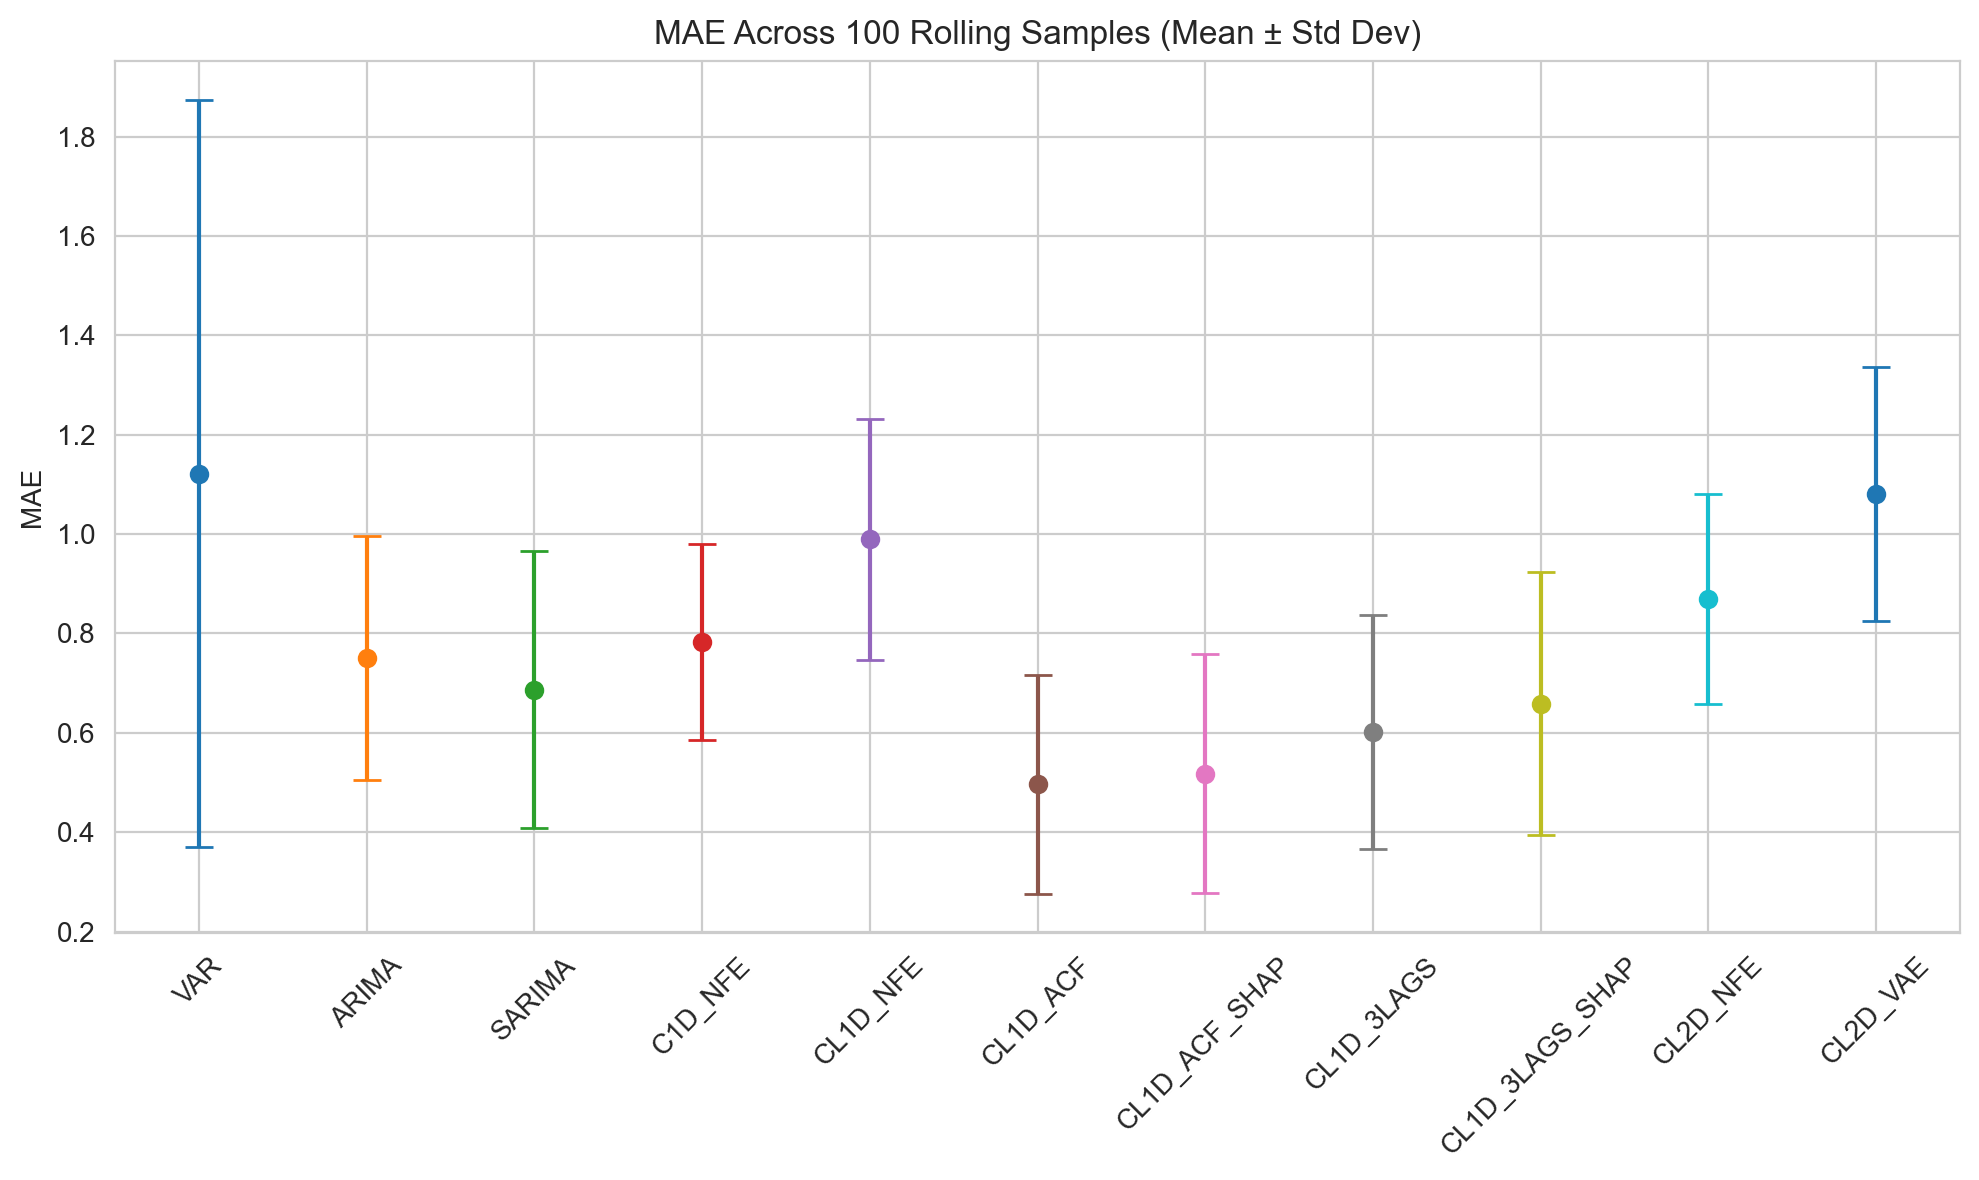

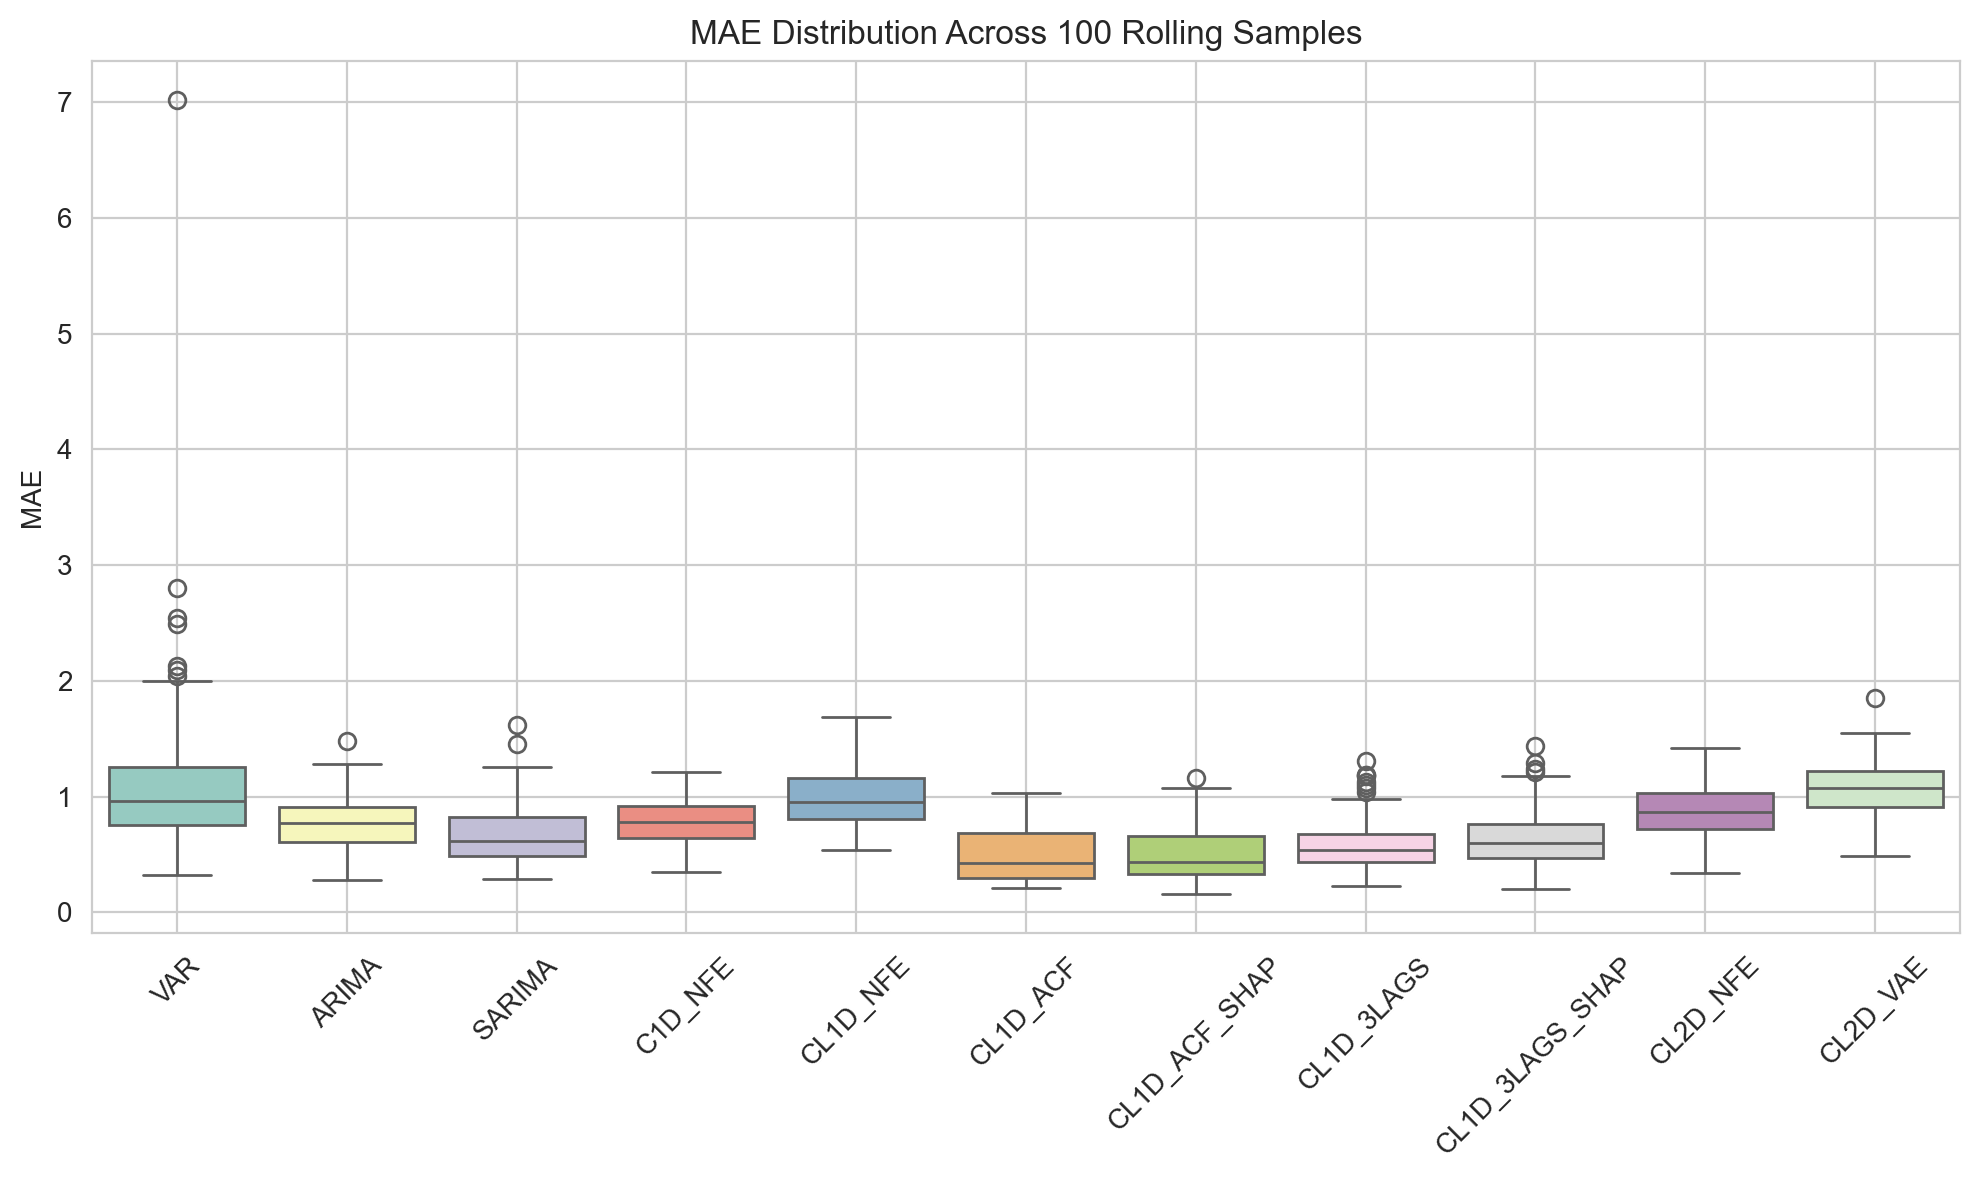

In [7]:
# Example usage
plot_metric_with_std(mae_df, "MAE")
# plot_metric_with_std(rmse_df, "RMSE")

# Example usage:
boxplot_metric_distribution(mae_df, "MAE")
# boxplot_metric_distribution(rmse_df, "RMSE")

In [8]:
# Melt the data for Seaborn
# Reset index to make 'Iteration' a column again
mae_df = mae_df.reset_index()
rmse_df = rmse_df.reset_index()
mae_melted = mae_df.melt(id_vars="Iteration", var_name="Model", value_name="MAE")
rmse_melted = rmse_df.melt(id_vars="Iteration", var_name="Model", value_name="RMSE")

# Compute mean MAE and RMSE per model
mean_mae = mae_df.drop(columns="Iteration", errors='ignore').mean()
mean_rmse = rmse_df.drop(columns="Iteration", errors='ignore').mean()


In [9]:
print(df.columns.tolist())


['VAR_step1', 'VAR_step2', 'VAR_step3', 'VAR_step4', 'VAR_step5', 'VAR_step6', 'VAR_step7', 'VAR_step8', 'VAR_step9', 'VAR_step10', 'VAR_step11', 'VAR_step12', 'ARIMA_step1', 'ARIMA_step2', 'ARIMA_step3', 'ARIMA_step4', 'ARIMA_step5', 'ARIMA_step6', 'ARIMA_step7', 'ARIMA_step8', 'ARIMA_step9', 'ARIMA_step10', 'ARIMA_step11', 'ARIMA_step12', 'SARIMA_step1', 'SARIMA_step2', 'SARIMA_step3', 'SARIMA_step4', 'SARIMA_step5', 'SARIMA_step6', 'SARIMA_step7', 'SARIMA_step8', 'SARIMA_step9', 'SARIMA_step10', 'SARIMA_step11', 'SARIMA_step12', 'C1D_NFE_step1', 'C1D_NFE_step2', 'C1D_NFE_step3', 'C1D_NFE_step4', 'C1D_NFE_step5', 'C1D_NFE_step6', 'C1D_NFE_step7', 'C1D_NFE_step8', 'C1D_NFE_step9', 'C1D_NFE_step10', 'C1D_NFE_step11', 'C1D_NFE_step12', 'CL1D_NFE_step1', 'CL1D_NFE_step2', 'CL1D_NFE_step3', 'CL1D_NFE_step4', 'CL1D_NFE_step5', 'CL1D_NFE_step6', 'CL1D_NFE_step7', 'CL1D_NFE_step8', 'CL1D_NFE_step9', 'CL1D_NFE_step10', 'CL1D_NFE_step11', 'CL1D_NFE_step12', 'CL1D_ACF_step1', 'CL1D_ACF_step2', 

/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_5153/541134766.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=mae_melted, x="Iteration", y="MAE", hue="Model", ci=95)


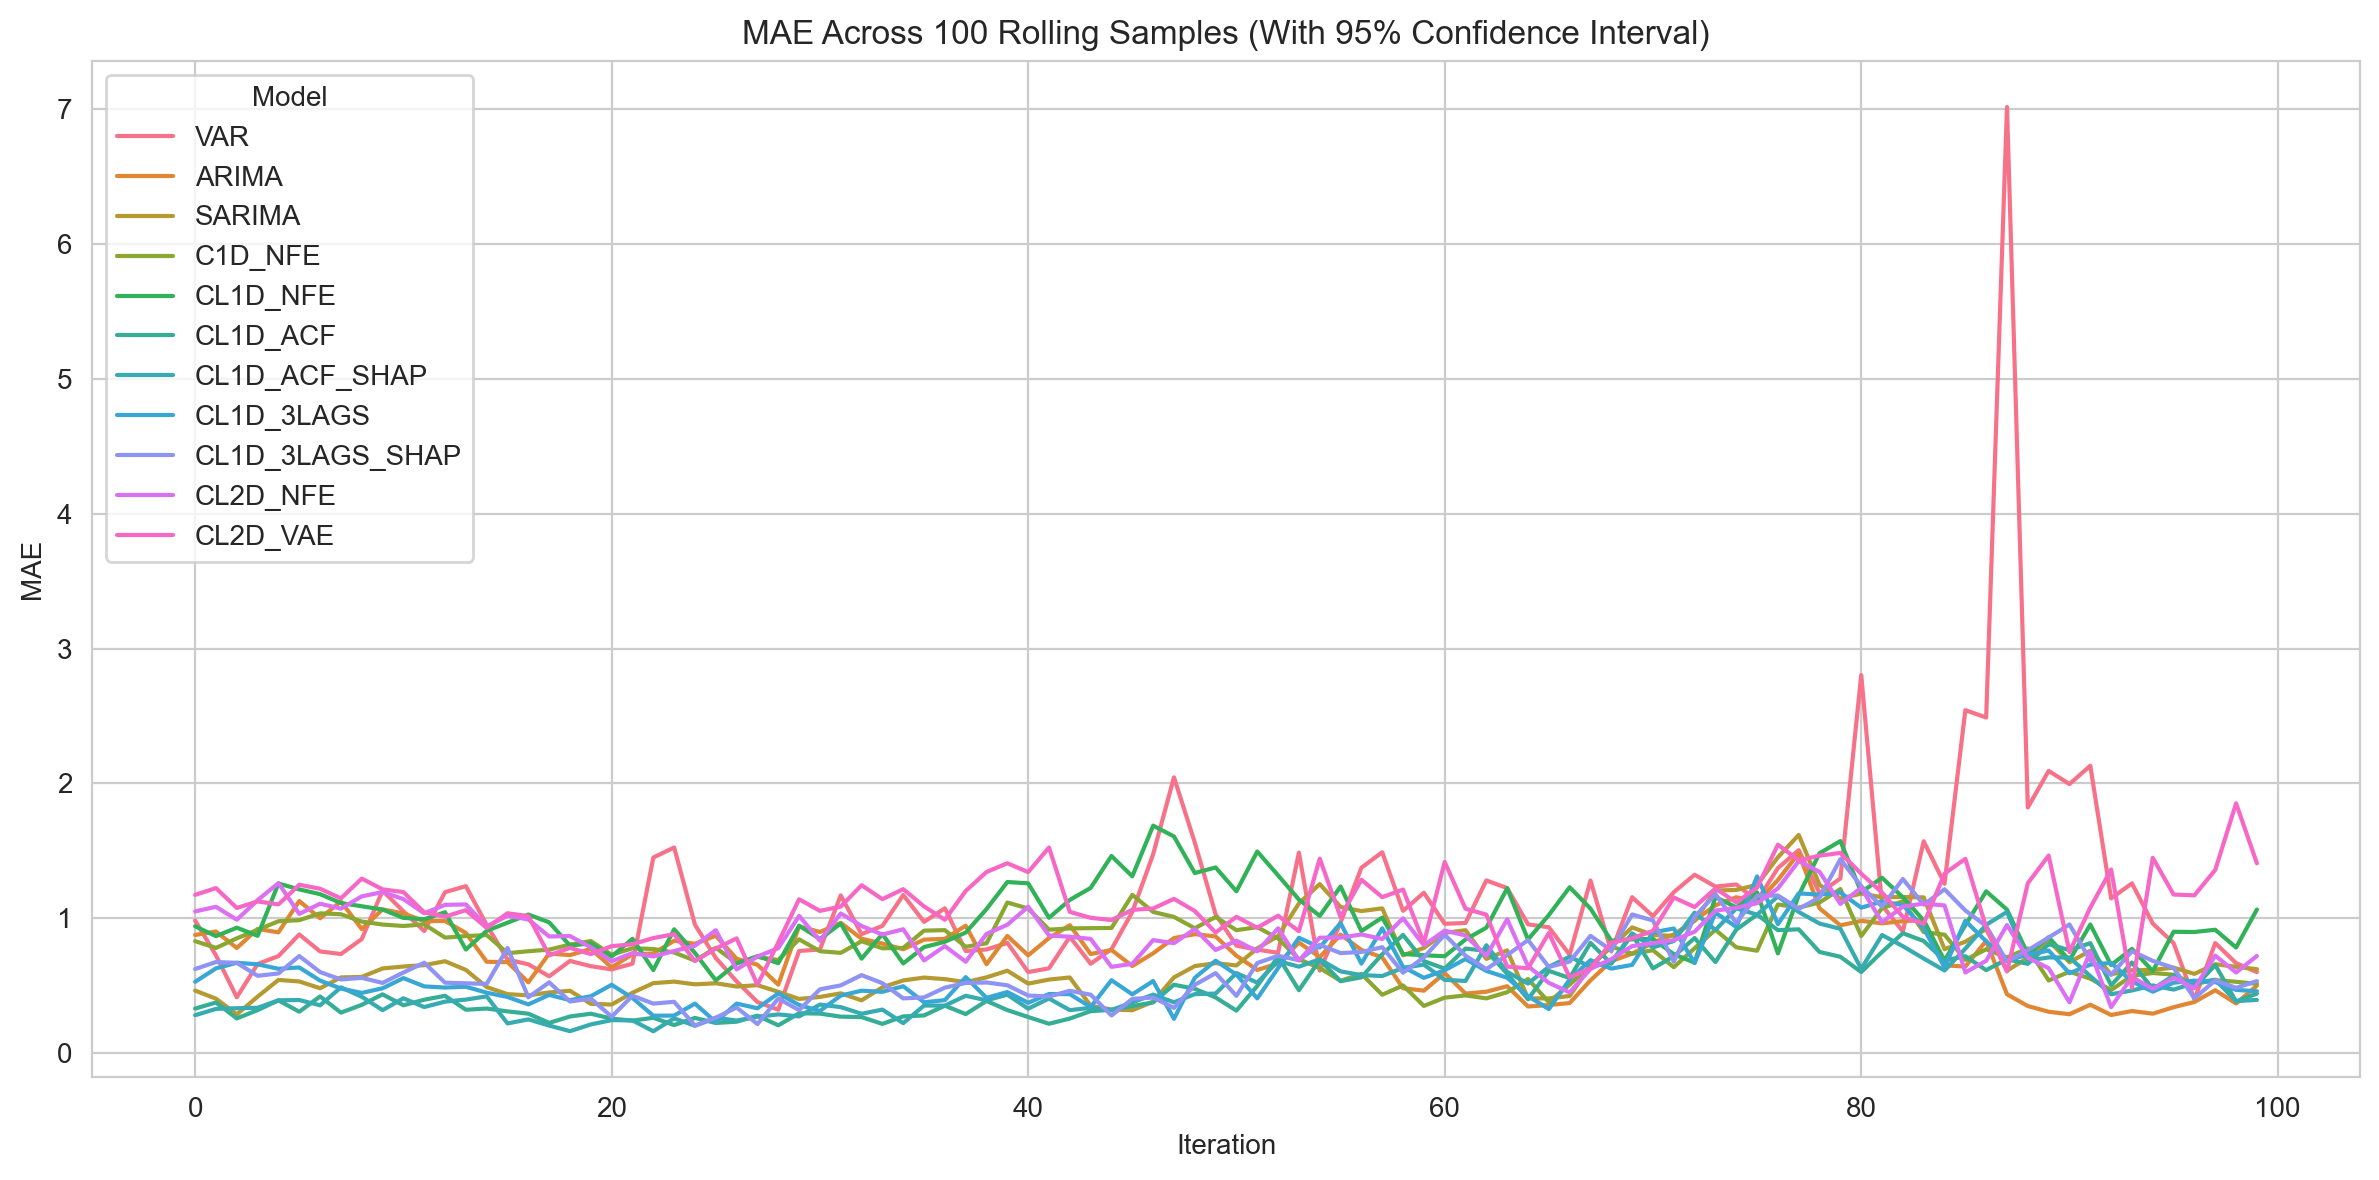

In [10]:

# Plot MAE
plt.figure(figsize=(12, 6))
sns.lineplot(data=mae_melted, x="Iteration", y="MAE", hue="Model", ci=95)
plt.title("MAE Across 100 Rolling Samples (With 95% Confidence Interval)")
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()

# # Plot RMSE
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=rmse_melted, x="Iteration", y="RMSE", hue="Model", ci=95)
# plt.title("RMSE Across 100 Rolling Samples (With 95% Confidence Interval)")
# plt.xlabel("Iteration")
# plt.ylabel("RMSE")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_5153/2234487417.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


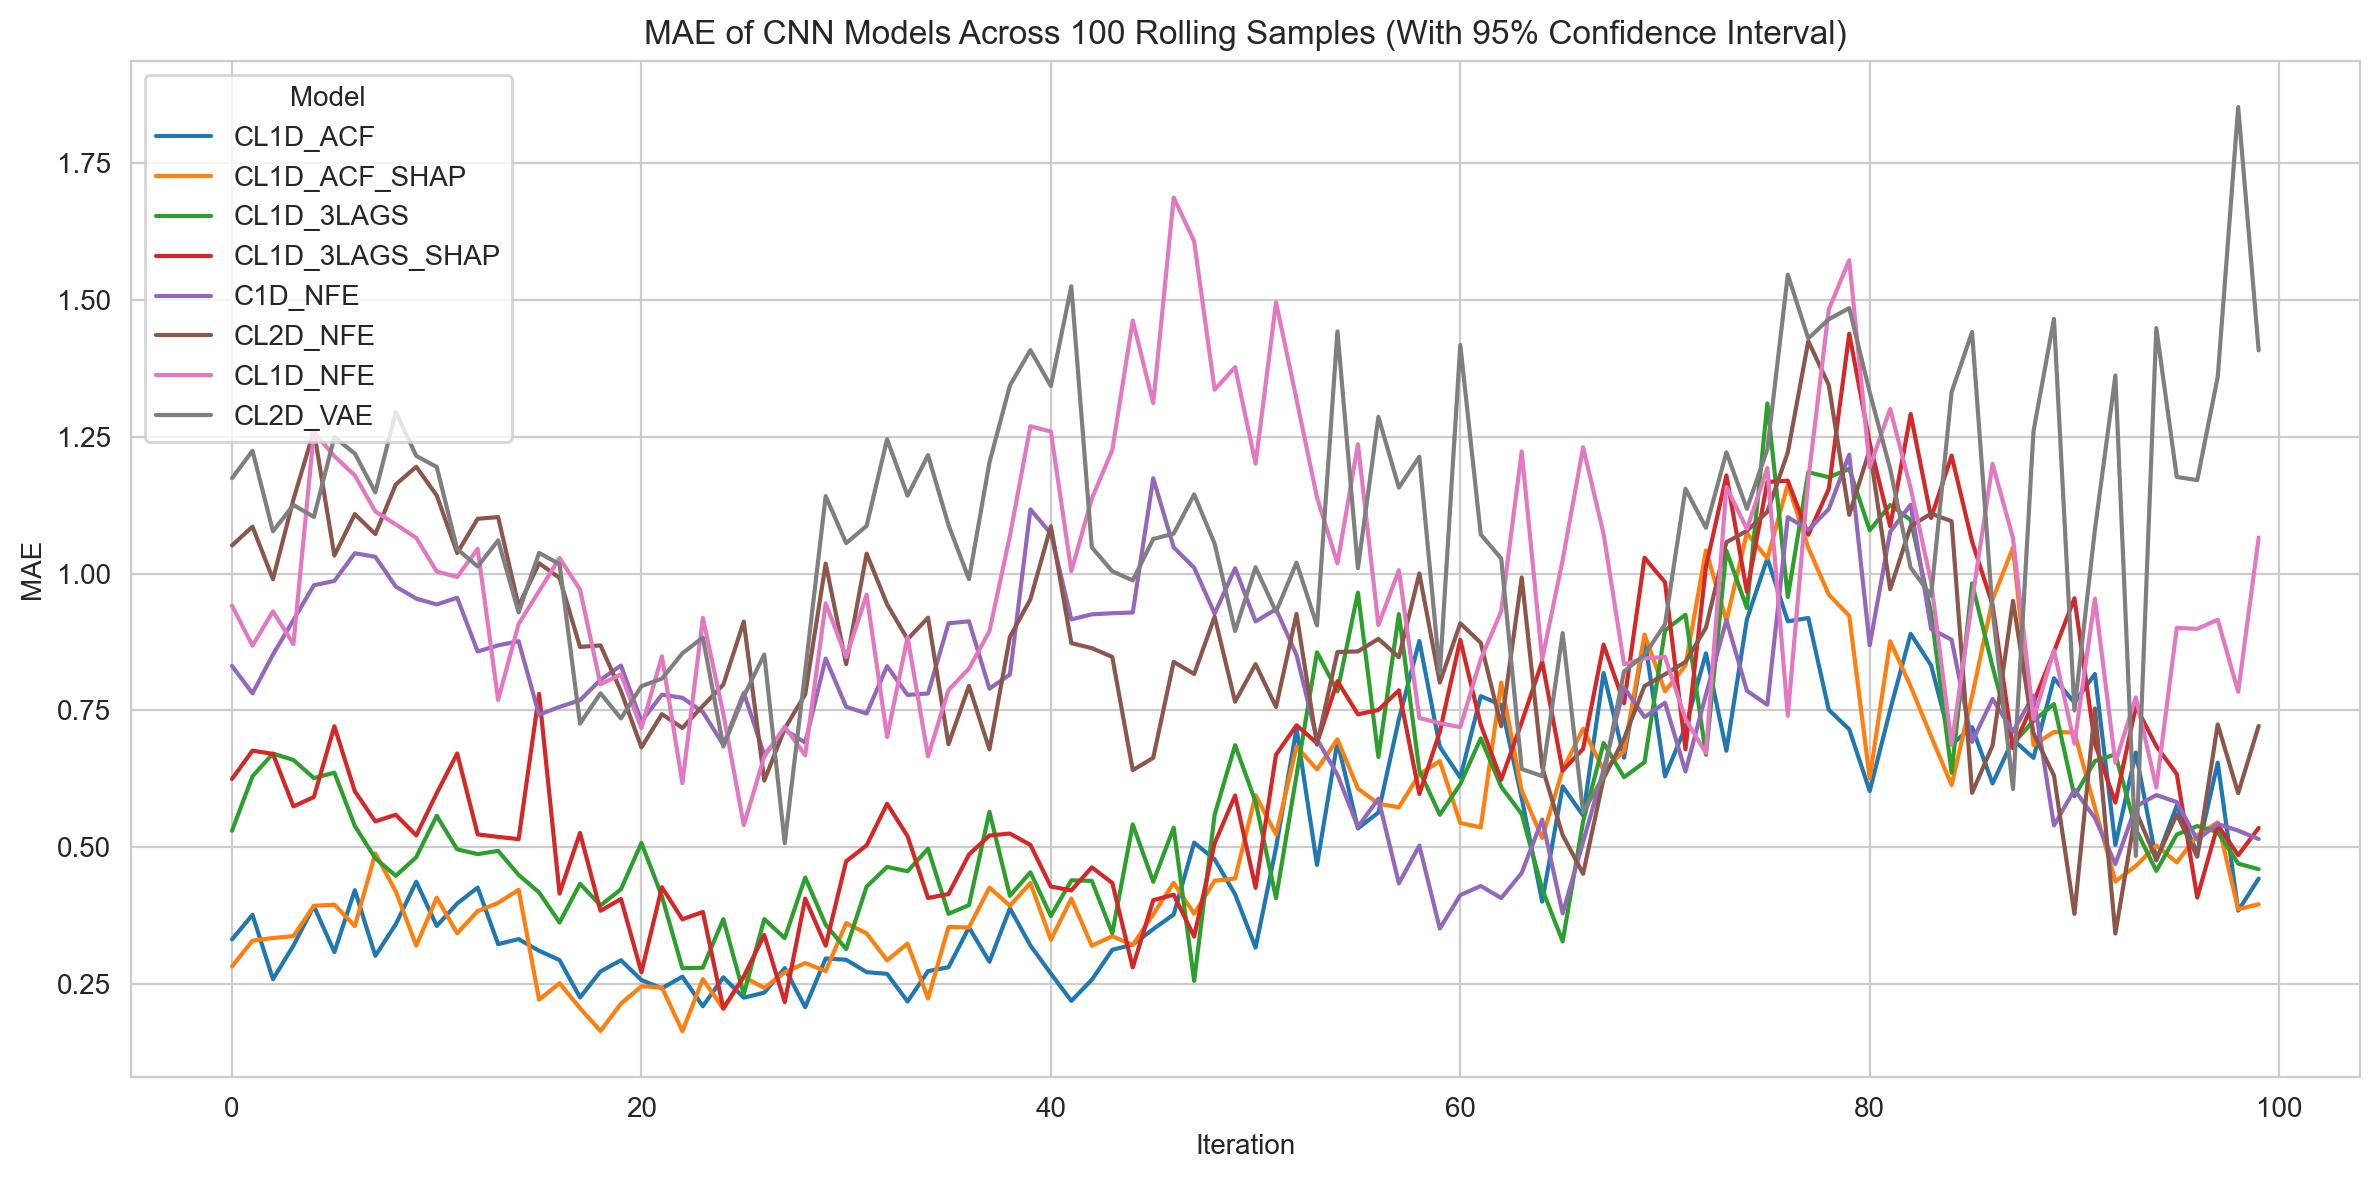

In [11]:
# Filter for CNN-based models only
cnn_models = mae_melted[mae_melted['Model'].str.contains("C", case=False)]

# Sort models by their average MAE
model_order = (
    cnn_models.groupby("Model")["MAE"]
    .mean()
    .sort_values()
    .index.tolist()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cnn_models,
    x="Iteration",
    y="MAE",
    hue="Model",
    hue_order=model_order,  # sorted by performance
    ci=95
)
plt.title("MAE of CNN Models Across 100 Rolling Samples (With 95% Confidence Interval)")
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Find iterations where base CNN has lowest MAE
cnn_only = cnn_models.copy()
pivoted = cnn_only.pivot(index='Iteration', columns='Model', values='MAE')
best_model = pivoted.idxmin(axis=1)

# Filter where base CNN was best
cnn_best_periods = best_model[best_model == 'C1D_NFE']
print("Base CNN outperformed all other CNN variants at the following iterations:\n", cnn_best_periods.index.tolist())


Base CNN outperformed all other CNN variants at the following iterations:
 [54, 57, 58, 59, 60, 61, 62, 63, 71, 74, 75, 89, 91]


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_5153/3078307377.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=cnn_models, x="Iteration", y="MAE", hue="Model", ci=95)


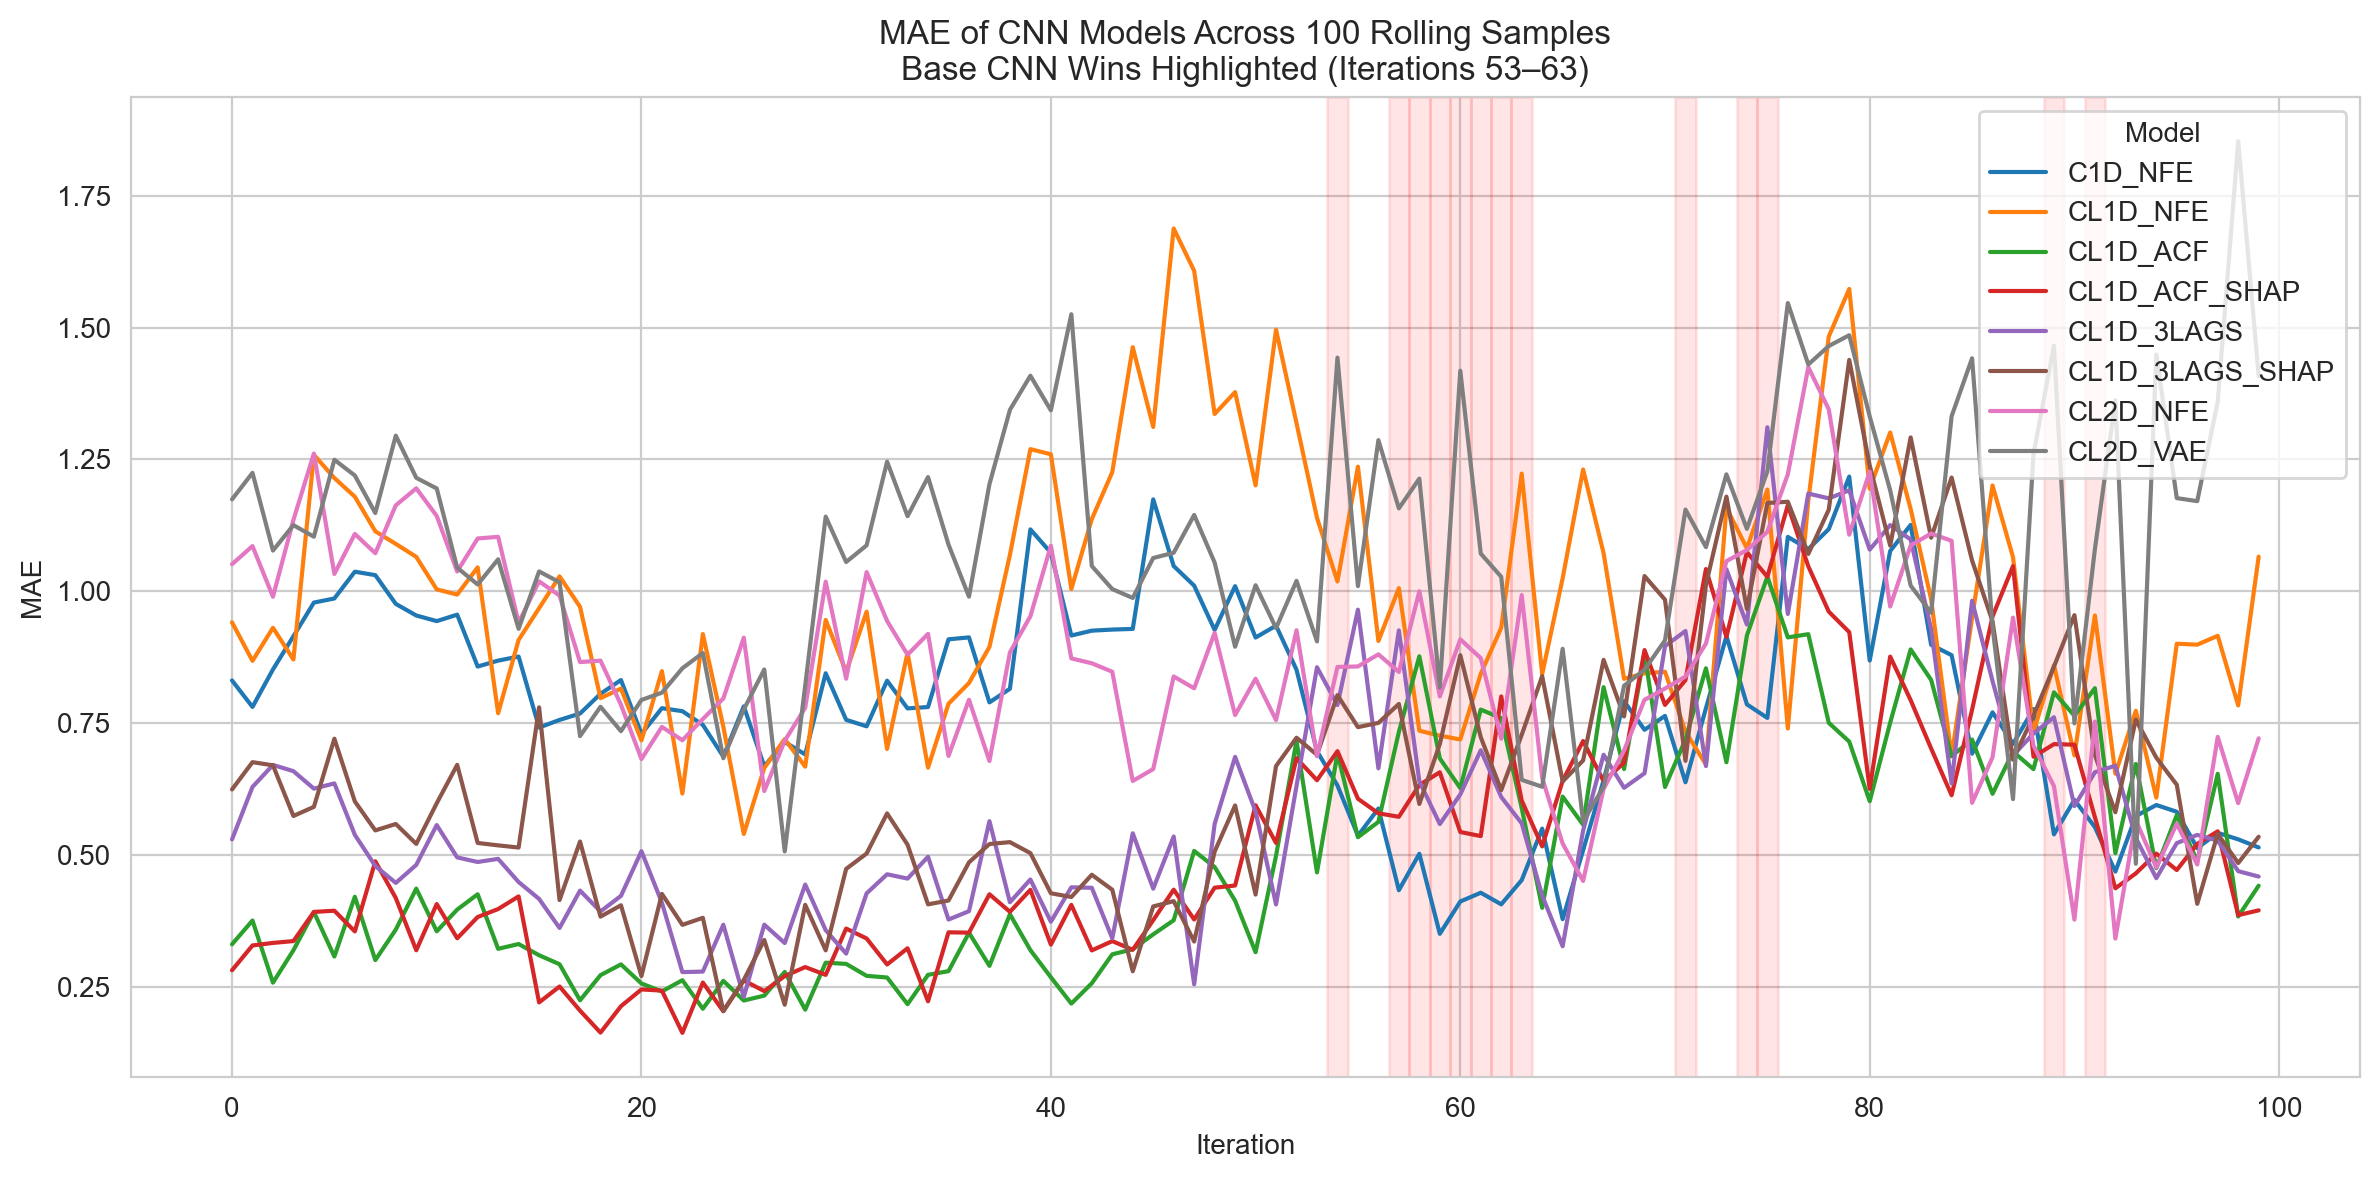

In [16]:
# Highlight base CNN wins
winning_iters = cnn_best_periods.index.tolist()

plt.figure(figsize=(12, 6))
sns.lineplot(data=cnn_models, x="Iteration", y="MAE", hue="Model", ci=95)

# Add vertical spans
for x in winning_iters:
    plt.axvspan(x-0.5, x+0.5, color='red', alpha=0.1)

plt.title("MAE of CNN Models Across 100 Rolling Samples\nBase CNN Wins Highlighted (Iterations 53–63)")
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_5153/3027447558.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


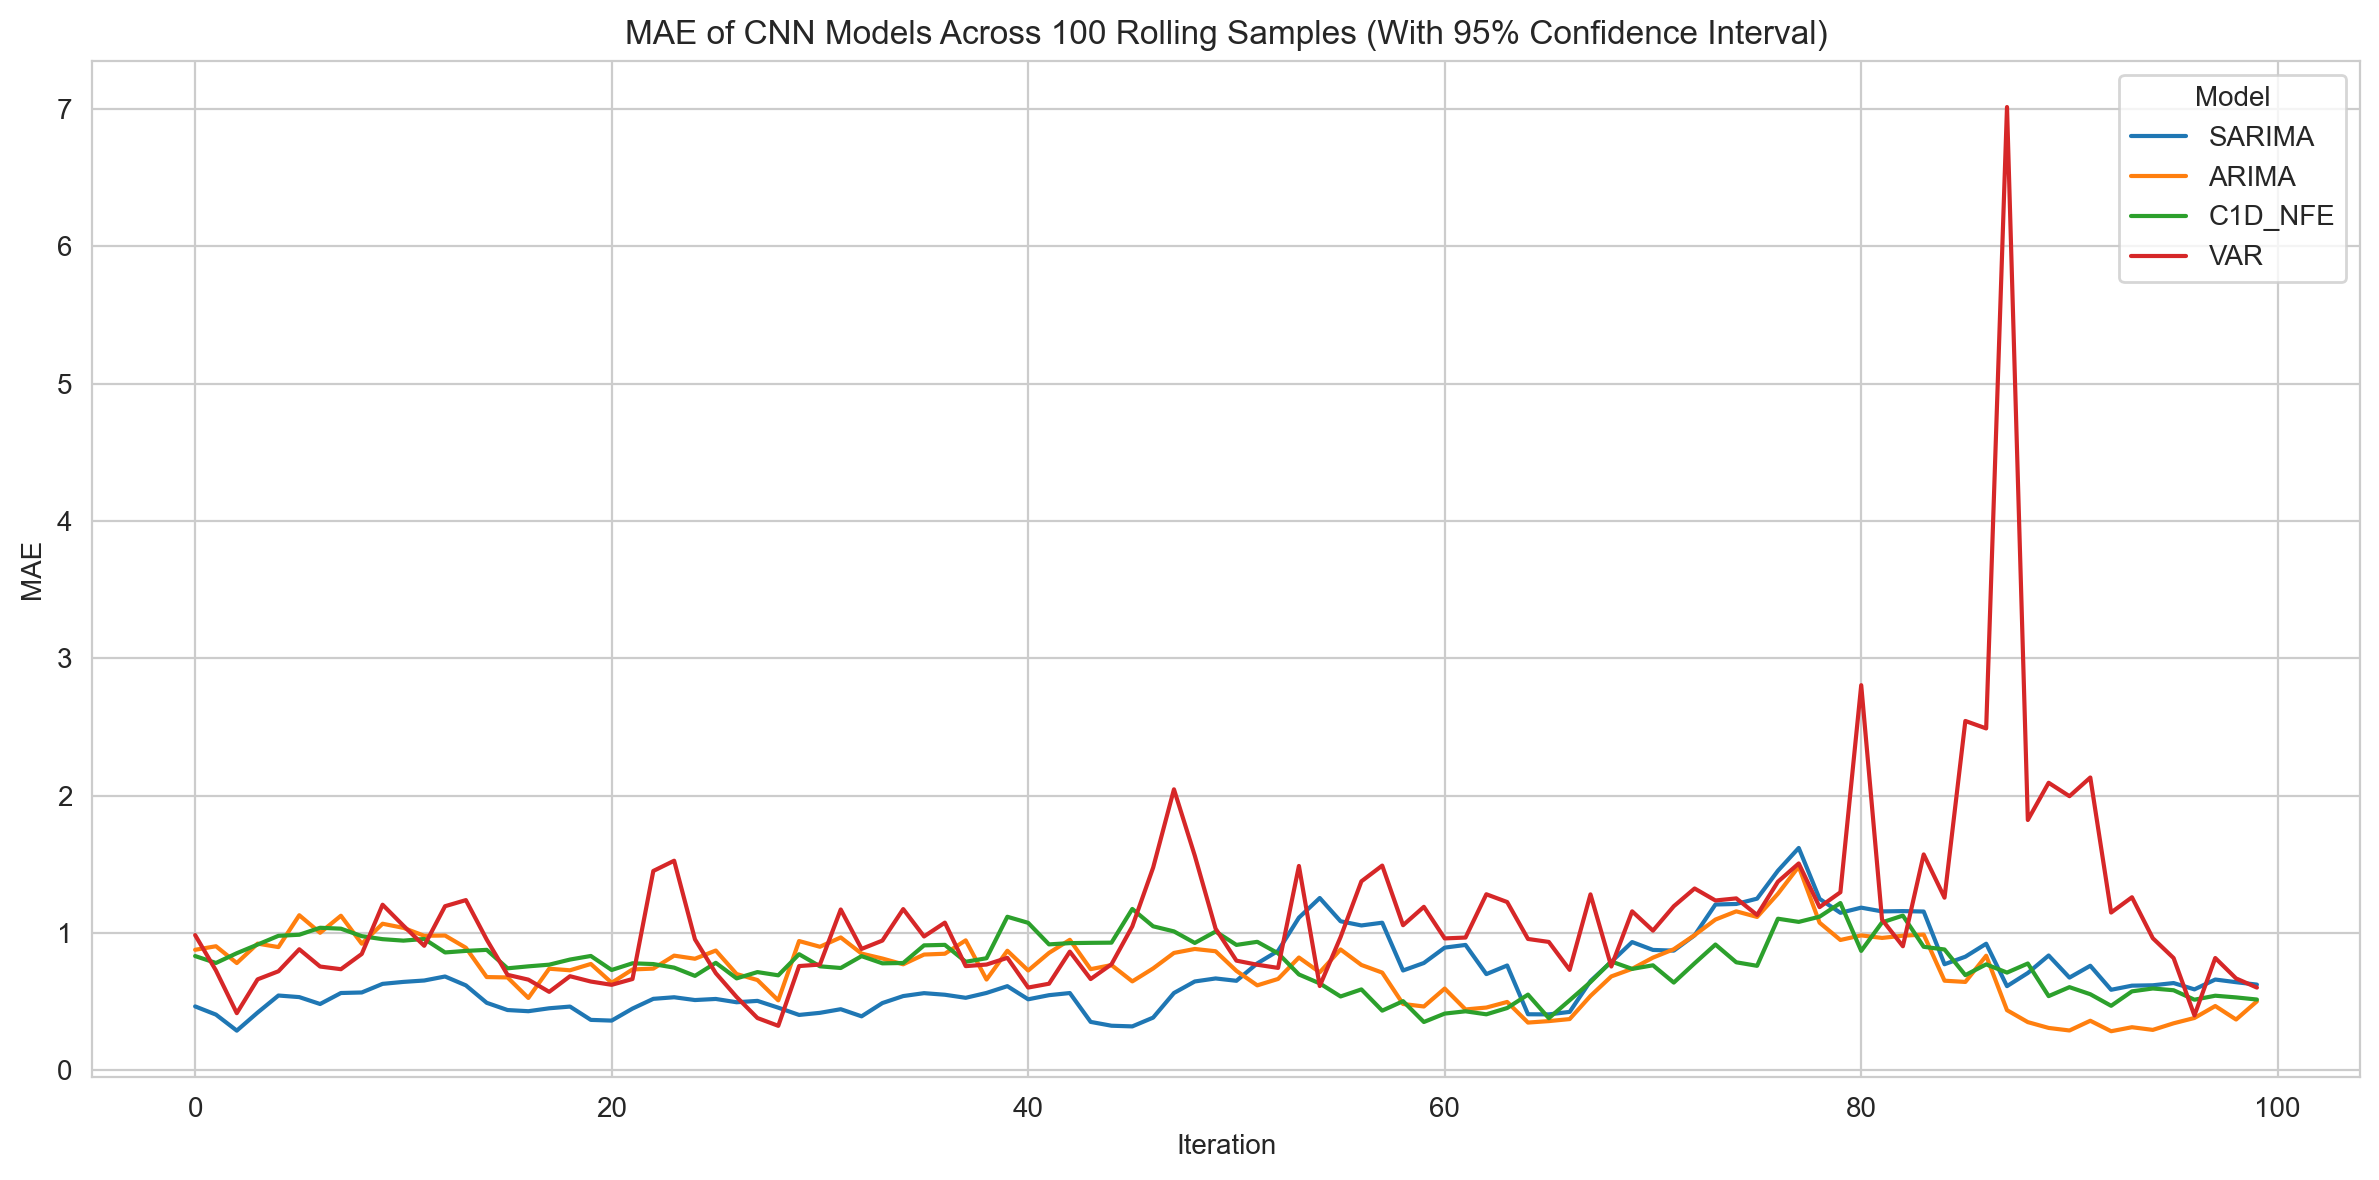

In [17]:
models_to_compare = ['C1D_NFE', 'SARIMA', 'ARIMA', 'VAR']

# Filter for CNN-based models only
# cnn_models = mae_melted[mae_melted['Model'].str.contains("CNN", case=False)]
comparison_models_df = mae_melted[mae_melted['Model'].isin(models_to_compare)].copy()

# Sort models by their average MAE
model_order = (
    comparison_models_df.groupby("Model")["MAE"]
    .mean()
    .sort_values()
    .index.tolist()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=comparison_models_df,
    x="Iteration",
    y="MAE",
    hue="Model",
    hue_order=model_order,  # sorted by performance
    ci=95
)
plt.title("MAE of CNN Models Across 100 Rolling Samples (With 95% Confidence Interval)")
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Find iterations where base CNN has lowest MAE
cnn_only = cnn_models.copy()
pivoted = cnn_only.pivot(index='Iteration', columns='Model', values='MAE')
best_model = pivoted.idxmin(axis=1)

# Filter where base CNN was best
cnn_best_periods = best_model[best_model == 'C1D_NFE']
print("Base CNN outperformed all other CNN variants at the following iterations:\n", cnn_best_periods.index.tolist())


Base CNN outperformed all other CNN variants at the following iterations:
 [54, 57, 58, 59, 60, 61, 62, 63, 71, 74, 75, 89, 91]


In [24]:
# Find iterations where base CNN has lowest MAE
cnn_and_others = comparison_models_df.copy()
pivoted_others = cnn_and_others.pivot(index='Iteration', columns='Model', values='MAE')
best_other_model = pivoted_others.idxmin(axis=1)

# Filter where base CNN was best
cnn_best_other_periods = best_other_model[best_other_model == 'C1D_NFE']
print("Base CNN outperformed all traditional models at the following iterations:\n", cnn_best_other_periods.index.tolist())

Base CNN outperformed all traditional models at the following iterations:
 [53, 55, 56, 57, 59, 60, 61, 62, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 83, 86]


In [23]:
# Starting date of first sample
start_date_first_sample = pd.Timestamp("2002-05-01")
window_length = 175  # 175 months per sample
num_iterations = 100

# Generate all iteration date ranges
iteration_ranges = {}

for i in range(1, num_iterations + 1):
    start = start_date_first_sample + pd.DateOffset(months=i - 1)
    end = start + pd.DateOffset(months=window_length - 1)
    iteration_ranges[i] = (start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))

# Example: Print for iteration 53 to 63 (Base CNN winning region)
best_periods = cnn_best_periods.index.tolist()
for i in best_periods:
    print(f"Iteration {i}: {iteration_ranges[i][0]} to {iteration_ranges[i][1]}")

Iteration 54: 2006-10-01 to 2021-04-01
Iteration 57: 2007-01-01 to 2021-07-01
Iteration 58: 2007-02-01 to 2021-08-01
Iteration 59: 2007-03-01 to 2021-09-01
Iteration 60: 2007-04-01 to 2021-10-01
Iteration 61: 2007-05-01 to 2021-11-01
Iteration 62: 2007-06-01 to 2021-12-01
Iteration 63: 2007-07-01 to 2022-01-01
Iteration 71: 2008-03-01 to 2022-09-01
Iteration 74: 2008-06-01 to 2022-12-01
Iteration 75: 2008-07-01 to 2023-01-01
Iteration 89: 2009-09-01 to 2024-03-01
Iteration 91: 2009-11-01 to 2024-05-01


In [25]:
for i in cnn_best_other_periods.index.tolist():
    print(f"Iteration {i}: {iteration_ranges[i][0]} to {iteration_ranges[i][1]}")

Iteration 53: 2006-09-01 to 2021-03-01
Iteration 55: 2006-11-01 to 2021-05-01
Iteration 56: 2006-12-01 to 2021-06-01
Iteration 57: 2007-01-01 to 2021-07-01
Iteration 59: 2007-03-01 to 2021-09-01
Iteration 60: 2007-04-01 to 2021-10-01
Iteration 61: 2007-05-01 to 2021-11-01
Iteration 62: 2007-06-01 to 2021-12-01
Iteration 63: 2007-07-01 to 2022-01-01
Iteration 69: 2008-01-01 to 2022-07-01
Iteration 70: 2008-02-01 to 2022-08-01
Iteration 71: 2008-03-01 to 2022-09-01
Iteration 72: 2008-04-01 to 2022-10-01
Iteration 73: 2008-05-01 to 2022-11-01
Iteration 74: 2008-06-01 to 2022-12-01
Iteration 75: 2008-07-01 to 2023-01-01
Iteration 76: 2008-08-01 to 2023-02-01
Iteration 77: 2008-09-01 to 2023-03-01
Iteration 80: 2008-12-01 to 2023-06-01
Iteration 83: 2009-03-01 to 2023-09-01
Iteration 86: 2009-06-01 to 2023-12-01


In [26]:
# Calculate the average MAE for each model
average_mae_per_model = mae_melted.groupby('Model')['MAE'].mean()

# Sort the models by their average MAE in ascending order (lower MAE is better)
ranked_models = average_mae_per_model.sort_values(ascending=True)

# Identify the overall best model
overall_best_model = ranked_models.index[0]
min_avg_mae = ranked_models.iloc[0]

print("--- Overall Model Performance (Average MAE) ---")
print(ranked_models.to_string()) # .to_string() for better multi-line printing

print(f"\nConclusion: The overall best model is '{overall_best_model}' with an average MAE of {min_avg_mae:.4f}.")


--- Overall Model Performance (Average MAE) ---
Model
CL1D_ACF           0.496094
CL1D_ACF_SHAP      0.517234
CL1D_3LAGS         0.601138
CL1D_3LAGS_SHAP    0.658439
SARIMA             0.687091
ARIMA              0.750070
C1D_NFE            0.782782
CL2D_NFE           0.868835
CL1D_NFE           0.989260
CL2D_VAE           1.080240
VAR                1.121170

Conclusion: The overall best model is 'CL1D_ACF' with an average MAE of 0.4961.


In [50]:
pivoted_mae = mae_melted.pivot(index='Iteration', columns='Model', values='MAE')

#--- 3. Overall Comparison: All Key Models (using Friedman Test) ---
print("\n### 3. Friedman Test: Base CNN, SARIMA, ARIMA, VAR ###")
# Collect the columns for the Friedman test
models_to_test = ['CNN', 'SARIMA', 'ARIMA', 'VAR']
# Filter pivoted_mae to only include these models and drop rows with any NaNs
# (Friedman test doesn't handle NaNs by default)
data_for_friedman = pivoted_mae[models_to_test].dropna()

if not data_for_friedman.empty and len(data_for_friedman.columns) == len(models_to_test):
    stat, p_value = stats.friedmanchisquare(*[data_for_friedman[model] for model in models_to_test])
    print(f"Friedman statistic: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < alpha:
        print(f"Conclusion: Reject the null hypothesis. There is a statistically significant difference (p < {alpha}) among the MAE of the models Base CNN, SARIMA, ARIMA, and VAR.")
        print("\n--- Performing Nemenyi Post-hoc Test (pairwise comparisons) ---")
        # To perform Nemenyi test, data needs to be in 'long' format or transposed
        # scikit_posthocs.posthoc_nemenyi_friedman expects data in specific format:
        # data = array of shape (n_samples, n_groups)
        # Or, data = array of shape (n_groups, n_samples) if passed as *args
        # Let's use the first form (samples x groups)
        posthoc_df = sp.posthoc_nemenyi_friedman(data_for_friedman.values)
        posthoc_df.columns = models_to_test
        posthoc_df.index = models_to_test
        print(posthoc_df.round(4)) # Round for cleaner output

        print("\nInterpretation of Nemenyi P-values:")
        print(f"Values less than {alpha} indicate a significant difference between the two models.")
        print("Note: Nemenyi test is more conservative than multiple t-tests.")

    else:
        print(f"Conclusion: Fail to reject the null hypothesis. There is no statistically significant difference (p >= {alpha}) among the MAE of the models Base CNN, SARIMA, ARIMA, and VAR.")
else:
    print("Not enough data or missing models for Friedman test.")


--- Statistical Significance Tests ---

### 1. Paired t-test: Base CNN vs. SARIMA ###
Paired t-test statistic: 0.4033
P-value: 0.6876
Conclusion: Fail to reject the null hypothesis. There is no statistically significant difference (p >= 0.05) between the MAE of Base CNN and SARIMA.


A regime or macroeconomic structure during this training/test window that aligns well with the base CNN's assumptions or features. What is common across this period is the global financial crisis. The base CNN which has no lagged values performed best consecutively for 11 subsamples. This could most likely infer that in periods of severe macroeconomic shocks,
What Does This Mean for Your Tool? "Having Base Models Perform Better in Periods of Extreme Shocks?"
This observation is significant and provides valuable insights into your models:

Robustness to Regime Shifts: It suggests that your base CNN might be more robust to periods of high volatility and structural breaks in your data. This is a highly desirable property for models used in dynamic environments like finance or economics.
Feature Engineering Importance: It highlights the importance of thoughtful feature engineering. While lagged features are often beneficial, their utility can diminish or even become detrimental during periods where underlying data patterns fundamentally change.
Model Selection and Ensemble Strategies:
For your educational tool, this suggests that a single model might not be optimal across all time periods.
You might consider a hybrid or ensemble approach:
Switching Models: Develop logic to identify periods of high volatility or potential shocks (e.g., based on statistical measures like volatility index, sudden price drops, etc.) and dynamically switch to the base CNN during these times.
Weighted Ensembling: Combine the predictions of different models, perhaps giving more weight to the base CNN during volatile periods and more weight to the lagged models during stable periods.
Further Research:
You could investigate the statistical properties of your time series data during the 2008 crisis period. Did stationarity break down? Were there significant shifts in variance or autocorrelation?
Analyze the features that the base CNN learned during this period. What kind of patterns was it picking up from the non-lagged data that allowed it to outperform?
Consider creating synthetic "shock" events in your data to further test this hypothesis and understand the limits of each model.
In summary, your observation is a strong indicator that the underlying dynamics of your data changed significantly during the 2008 financial crisis, and your base CNN model (which relies on immediate input rather than historical patterns) was better equipped to handle this regime shift or extreme shock. This is a powerful insight into the strengths and weaknesses of your different model architectures


Also the base model starts to perform better towards the end of 2023, 2024.

Germany CPI: Structural Breaks Towards 2023-2024
The period from late 2021 through 2024 has been marked by unprecedented volatility and significant structural breaks in inflation dynamics globally, and particularly in Germany. This period can be broadly characterized by:

Post-COVID Supply Chain Shocks & Pent-up Demand (2021-2022): As economies reopened, a surge in demand met with disrupted global supply chains, leading to initial inflationary pressures.
Energy Crisis (2022 - early 2023): The geopolitical events (especially the war in Ukraine) led to a massive spike in energy prices, particularly natural gas, which heavily impacted Germany due to its reliance on Russian gas. This was a direct, substantial, and immediate shock that drove inflation to multi-decade highs.
Inflation Peaking and Disinflation (Mid-2023 onwards): Following aggressive interest rate hikes by the European Central Bank (ECB), easing energy prices, and some normalization of supply chains, inflation began to decelerate significantly from its peak. This is known as disinflation.


Conclusion: "Base Models Performing Better in Periods of Extreme Shocks and Rapid Regime Shifts"
Your findings consistently point to a crucial characteristic of your base CNN model: it appears to be more robust and adaptable during periods of significant economic upheaval, structural breaks, and rapid shifts in data regimes.

Both the 2008 financial crisis (a sharp contraction/downturn) and the post-COVID, energy-crisis, and disinflationary period (periods of extreme volatility and rapid shifts in both directions) challenge models that rely heavily on the stability of past patterns and lagged relationships. In such environments, a model that can react quickly to the most current information, unburdened by potentially misleading historical correlations, seems to gain an advantage.

This is a valuable insight for your tool's design. It suggests that for economic forecasting, especially in volatile times, simpler (in terms of explicit lagged features) or more instantaneously responsive models can be surprisingly effective. This also strengthens the argument for considering adaptive modeling strategies, where different models or ensembles might be favored depending on the prevailing economic conditions.

Conclusion: "Base Models Performing Better in Periods of Extreme Shocks and Rapid Regime Shifts"
Your findings consistently point to a crucial characteristic of your base CNN model: it appears to be more robust and adaptable during periods of significant economic upheaval, structural breaks, and rapid shifts in data regimes.

Both the 2008 financial crisis (a sharp contraction/downturn) and the post-COVID, energy-crisis, and disinflationary period (periods of extreme volatility and rapid shifts in both directions) challenge models that rely heavily on the stability of past patterns and lagged relationships. In such environments, a model that can react quickly to the most current information, unburdened by potentially misleading historical correlations, seems to gain an advantage.

This is a valuable insight for your tool's design. It suggests that for economic forecasting, especially in volatile times, simpler (in terms of explicit lagged features) or more instantaneously responsive models can be surprisingly effective. This also strengthens the argument for considering adaptive modeling strategies, where different models or ensembles might be favored depending on the prevailing economic conditions.

Detected model prefixes: ['ARIMA', 'CNN', 'CNN_5LAGS', 'CNN_ACF_PACF', 'CNN_SHAP', 'SARIMA', 'VAR']


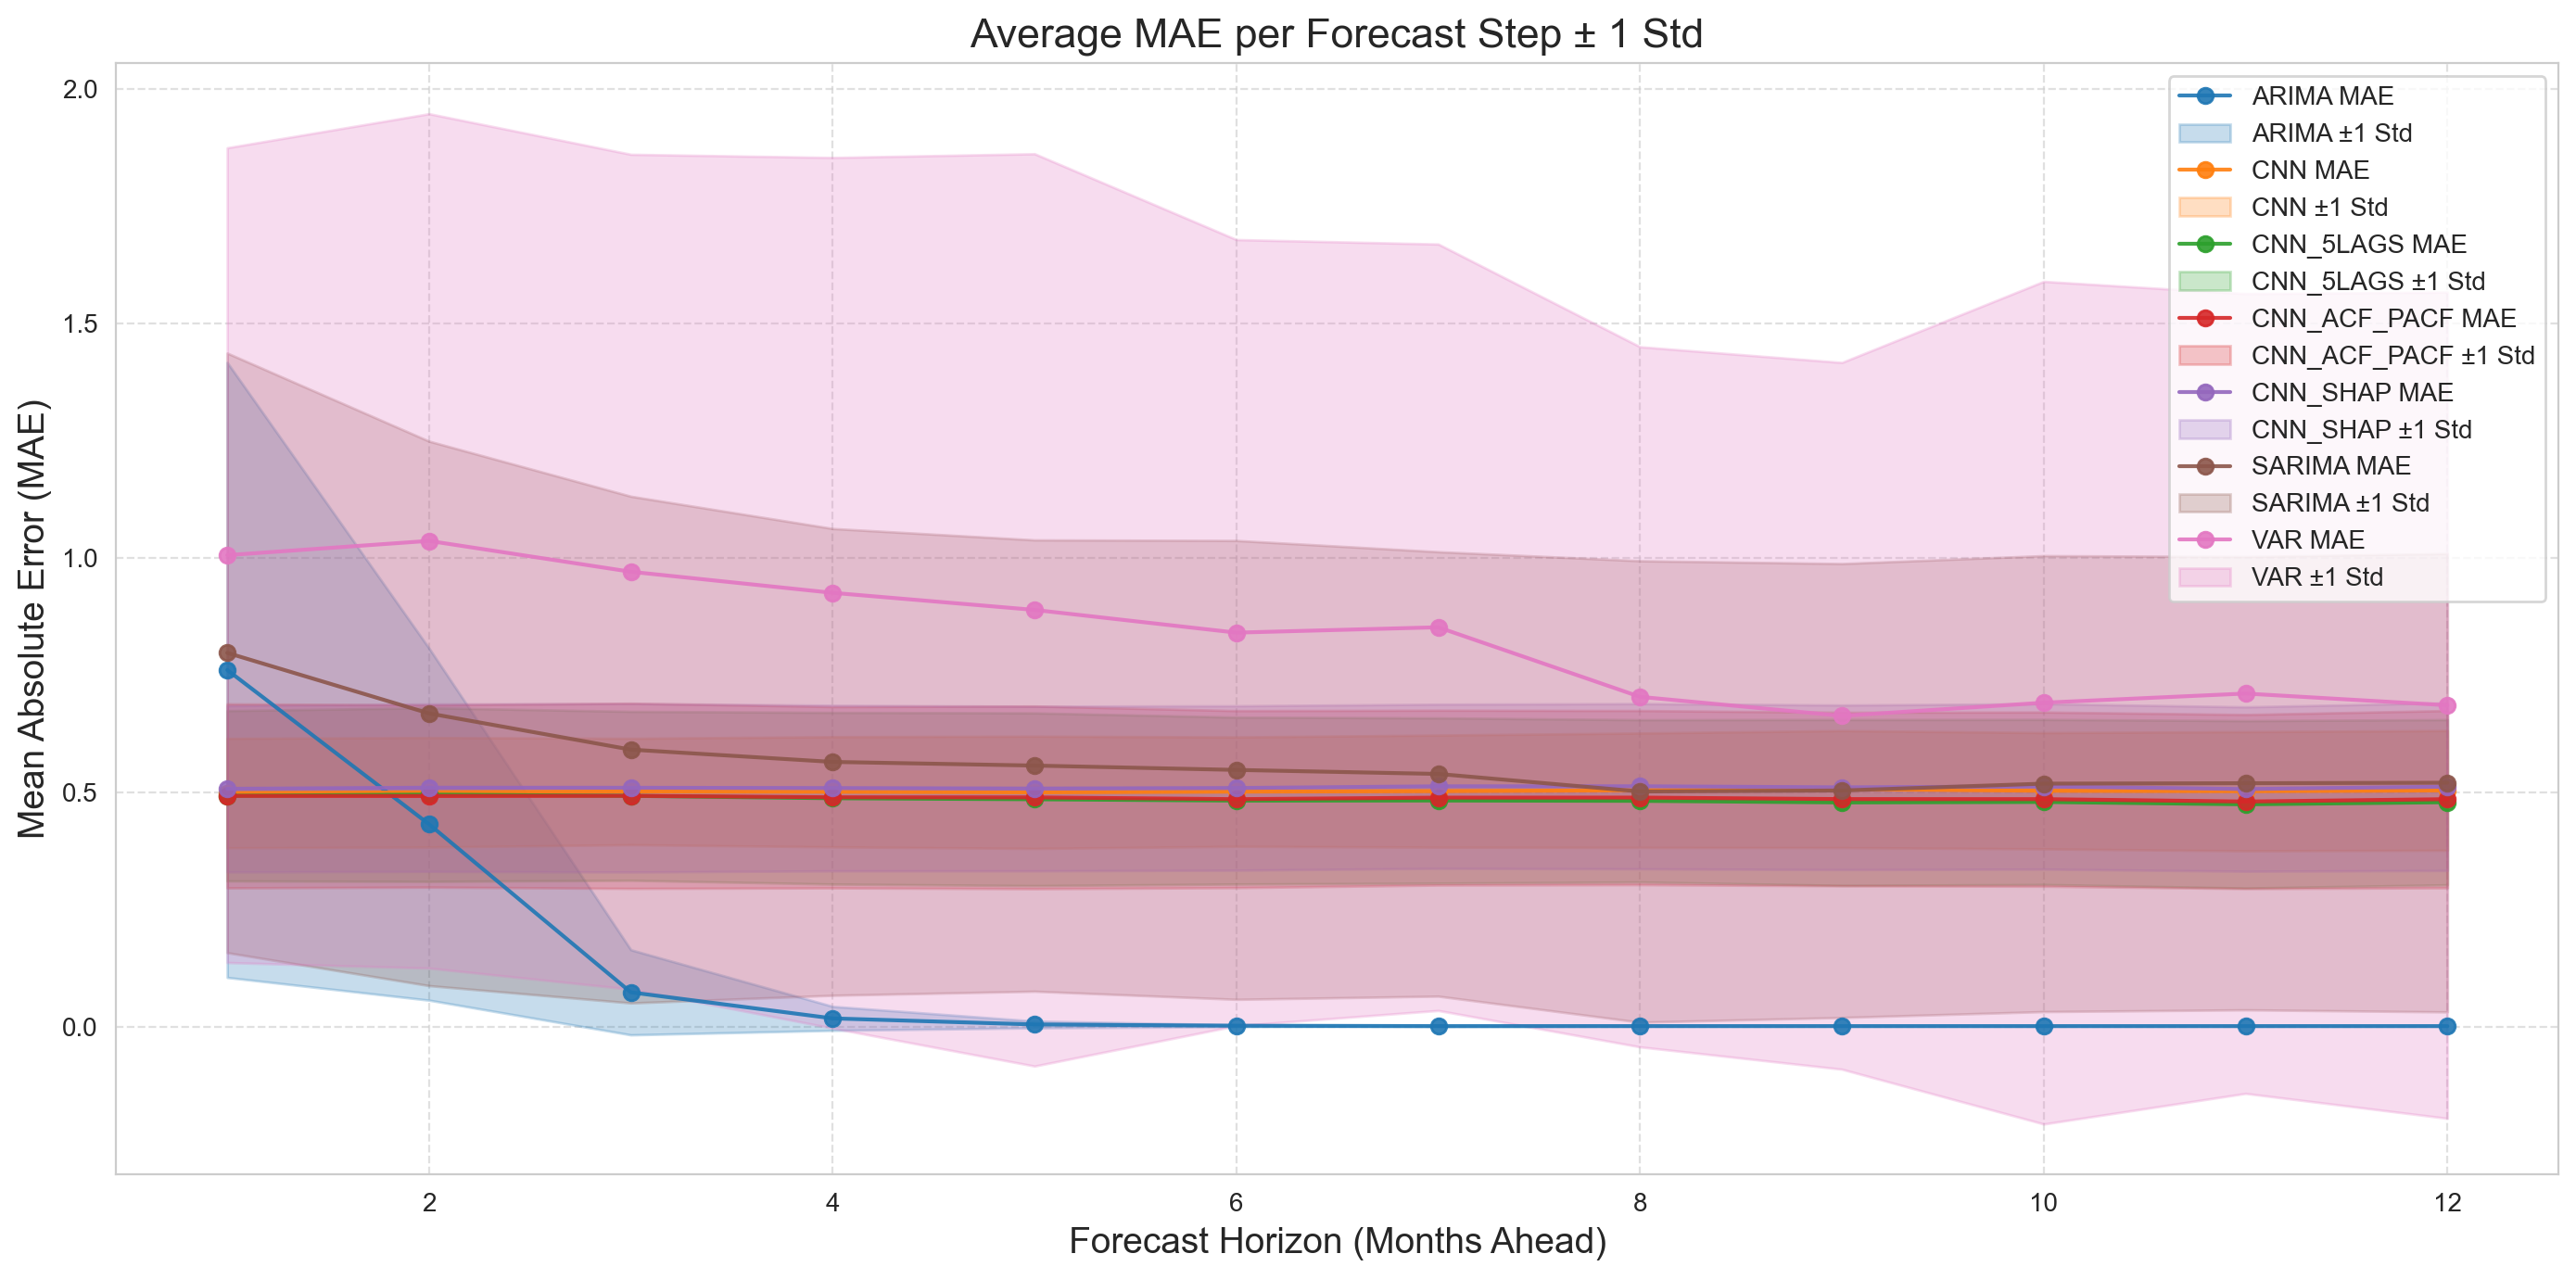

In [12]:
  # Adjust filename/path as needed

# Identify models by common prefixes (adjust if yours differ)
# model_prefixes = ['cnn', 'cnn_5lags', 'cnn_acf_pacf', 'cnn_shap', 'sarima', 'arima', 'var']
# test_size = 12  # Number of forecast steps

# Plot settings
# plt.figure(figsize=(14, 7))
colors = {
    'cnn': 'blue',
    'cnn_5lags': 'green',
    'cnn_acf_pacf': 'orange',
    'cnn_shap': 'darkred',
    'sarima': 'deeppink',
    'arima': 'indigo',
    'var': 'black',
}


# Extract unique model prefixes from columns
model_prefixes = sorted(set(col.split('_step')[0] for col in df.columns if '_step' in col))
print("Detected model prefixes:", model_prefixes)

# Plot setup
plt.figure(figsize=(14, 7))
test_size = 12
colors = plt.cm.tab10.colors  # 10 standard colors for cycling

# Loop through models and plot MAE + confidence interval
for i, model in enumerate(model_prefixes):
    step_cols = [f"{model}_step{j+1}" for j in range(test_size)]

    if not all(col in df.columns for col in step_cols):
        print(f"Skipping {model}: missing forecast steps")
        continue

    model_data = df[step_cols].values  # Shape (100, 12)
    mean_mae = np.mean(np.abs(model_data), axis=0)
    std_mae = np.std(np.abs(model_data), axis=0)

    plt.plot(range(1, test_size + 1), mean_mae, label=f'{model} MAE',
             marker='o', color=colors[i % len(colors)], alpha=0.9)

    plt.fill_between(range(1, test_size + 1),
                     mean_mae - std_mae,
                     mean_mae + std_mae,
                     color=colors[i % len(colors)],
                     alpha=0.25, label=f'{model} ±1 Std')

# Plot styling
plt.title("Average MAE per Forecast Step ± 1 Std", fontsize=16)
plt.xlabel("Forecast Horizon (Months Ahead)", fontsize=14)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=10, loc="upper right")
plt.tight_layout()
plt.show()



In [ ]:
# Pseudocode to reconstruct absolute errors
errors_dict = {}

for model in model_prefixes:
    step_cols = [f"{model}_step{j+1}" for j in range(12)]
    if not all(col in df.columns for col in step_cols):
        continue

    model_forecasts = df[step_cols].values  # shape (100, 12)

    model_errors = []

    for i in range(100):  # sample-wise
        true_values = get_true_values_for_sample(i)  # shape (12,)
        forecast_values = model_forecasts[i]
        abs_error = np.abs(true_values - forecast_values)  # shape (12,)
        model_errors.append(abs_error)

    errors_dict[model] = np.array(model_errors)  # shape (100, 12)


In [67]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
mae_results = {}
rmse_results = {}

for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    filename_rmse = f"rmses_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))
        df_rmse = pd.read_csv(os.path.join(r_result_Dir, filename_rmse))
        mean_maes = df_mae.mean()
        mean_rmses = df_rmse.mean()
        mae_results[f"{steps}_month_ahead"] = mean_maes.to_dict()
        rmse_results[f"{steps}_month_ahead"] = mean_rmses.to_dict()
    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' or '{filename_rmse}' not found for {steps}-month ahead.")

print("\nMean MAE and RMSE for each model across different forecast horizons:")
for horizon in mae_results.keys():
    print(f"\n{horizon}:")
    mae_means = mae_results.get(horizon, {})
    rmse_means = rmse_results.get(horizon, {})
    for model in mae_means.keys():
        mean_mae = mae_means.get(model, float('nan'))
        mean_rmse = rmse_means.get(model, float('nan'))
        print(f"  {model}: MAE={mean_mae:.4f}, RMSE={mean_rmse:.4f}")


Mean MAE and RMSE for each model across different forecast horizons:

1_month_ahead:
  CNN-LSTM: MAE=0.7483, RMSE=0.9969
  CNN-LSTM + VS: MAE=0.7472, RMSE=0.9967
  SARIMA: MAE=0.7616, RMSE=1.0089
  ARIMA: MAE=0.7595, RMSE=1.0081
  VAR: MAE=1.0213, RMSE=1.3029

2_month_ahead:
  CNN-LSTM: MAE=0.7485, RMSE=0.9963
  CNN-LSTM + VS: MAE=0.7480, RMSE=0.9955
  SARIMA: MAE=0.7613, RMSE=1.0086
  ARIMA: MAE=0.7596, RMSE=1.0082
  VAR: MAE=1.0223, RMSE=1.3012

3_month_ahead:
  CNN-LSTM: MAE=0.7490, RMSE=0.9963
  CNN-LSTM + VS: MAE=0.7481, RMSE=0.9973
  SARIMA: MAE=0.7613, RMSE=1.0085
  ARIMA: MAE=0.7596, RMSE=1.0082
  VAR: MAE=1.0349, RMSE=1.3164

4_month_ahead:
  CNN-LSTM: MAE=0.7490, RMSE=0.9973
  CNN-LSTM + VS: MAE=0.7482, RMSE=0.9970
  SARIMA: MAE=0.7615, RMSE=1.0086
  ARIMA: MAE=0.7595, RMSE=1.0082
  VAR: MAE=1.0383, RMSE=1.3182

5_month_ahead:
  CNN-LSTM: MAE=0.7494, RMSE=0.9987
  CNN-LSTM + VS: MAE=0.7478, RMSE=0.9968
  SARIMA: MAE=0.7617, RMSE=1.0088
  ARIMA: MAE=0.7597, RMSE=1.0081
  VAR:

In [68]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]
alpha = 0.05  # Significance level
normality_results_all_horizons = {}

print("Normality Tests (Shapiro-Wilk) for Model Performance (MAE):\n")

# --- First Pass: Test for Normality ---
for steps in forecast_horizons:
    filename = f"maess_{steps}_month_ahead.csv"
    normality_results_for_horizon = {}
    try:
        df_maes = pd.read_csv(os.path.join(m_result_Dir, filename))
        print(f"--- Forecast Horizon: {steps}_month_ahead ---")
        for model in models:
            try:
                statistic, p_value = stats.shapiro(df_maes[model])
                is_normal = p_value > alpha
                normality_results_for_horizon[model] = is_normal
                print(f"  Model: {model}, Shapiro-Wilk Statistic: {statistic:.4f}, P-value: {p_value:.4f}, Likely Normal: {is_normal}")
            except Exception as e:
                print(f"  Error during normality test for {model}: {e}")
                normality_results_for_horizon[model] = False # Assume not normal if error
        normality_results_all_horizons[f"{steps}_month_ahead"] = normality_results_for_horizon
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found for {steps}-month ahead.\n")
        normality_results_all_horizons[f"{steps}_month_ahead"] = {model: False for model in models}

print("\nPairwise Significance Tests based on Normality (alpha=0.05):\n")


Normality Tests (Shapiro-Wilk) for Model Performance (MAE):

--- Forecast Horizon: 1_month_ahead ---
  Model: CNN-LSTM, Shapiro-Wilk Statistic: 0.9684, P-value: 0.0167, Likely Normal: False
  Model: CNN-LSTM + VS, Shapiro-Wilk Statistic: 0.9666, P-value: 0.0122, Likely Normal: False
  Model: SARIMA, Shapiro-Wilk Statistic: 0.9768, P-value: 0.0752, Likely Normal: True
  Model: ARIMA, Shapiro-Wilk Statistic: 0.9763, P-value: 0.0687, Likely Normal: True
  Model: VAR, Shapiro-Wilk Statistic: 0.9805, P-value: 0.1455, Likely Normal: True
--- Forecast Horizon: 2_month_ahead ---
  Model: CNN-LSTM, Shapiro-Wilk Statistic: 0.9743, P-value: 0.0477, Likely Normal: False
  Model: CNN-LSTM + VS, Shapiro-Wilk Statistic: 0.9695, P-value: 0.0204, Likely Normal: False
  Model: SARIMA, Shapiro-Wilk Statistic: 0.9753, P-value: 0.0564, Likely Normal: True
  Model: ARIMA, Shapiro-Wilk Statistic: 0.9762, P-value: 0.0673, Likely Normal: True
  Model: VAR, Shapiro-Wilk Statistic: 0.9872, P-value: 0.4502, Likel

In [28]:
# --- Second Pass: Perform Significance Tests ---
for steps in forecast_horizons:
    filename = f"maess_{steps}_month_ahead.csv"
    try:
        df_maes = pd.read_csv(os.path.join(m_result_Dir, filename))
        normality_results_for_horizon = normality_results_all_horizons.get(f"{steps}_month_ahead", {})
        print(f"--- Forecast Horizon: {steps}_month_ahead ---")
        for model_pair in combinations(models, 2):
            model1, model2 = model_pair
            mae_model1 = df_maes[model1]
            mae_model2 = df_maes[model2]
            is_normal_model1 = normality_results_for_horizon.get(model1, False)
            is_normal_model2 = normality_results_for_horizon.get(model2, False)

            print(f"  Comparing {model1} vs {model2}:")
            if is_normal_model1 and is_normal_model2:
                # Perform Independent Samples t-test
                statistic, p_value = stats.ttest_ind(mae_model1, mae_model2)
                test_name = "Independent Samples t-test"
            else:
                # Perform Mann-Whitney U test
                statistic, p_value = stats.mannwhitneyu(mae_model1, mae_model2, alternative='two-sided') # Using 'two-sided' as a general approach
                test_name = "Mann-Whitney U test"

            significant = p_value < alpha
            print(f"    Test: {test_name}, Statistic: {statistic:.4f}, P-value: {p_value:.4f}, Significant Difference (alpha={alpha}): {significant}")

    except FileNotFoundError:
        print(f"Error: File '{filename}' not found for {steps}-month ahead, skipping significance tests.\n")

--- Forecast Horizon: 1_month_ahead ---
  Comparing CNN-LSTM vs CNN-LSTM + VS:
    Test: Mann-Whitney U test, Statistic: 5068.0000, P-value: 0.8690, Significant Difference (alpha=0.05): False
  Comparing CNN-LSTM vs SARIMA:
    Test: Mann-Whitney U test, Statistic: 4495.0000, P-value: 0.2177, Significant Difference (alpha=0.05): False
  Comparing CNN-LSTM vs ARIMA:
    Test: Mann-Whitney U test, Statistic: 4557.0000, P-value: 0.2796, Significant Difference (alpha=0.05): False
  Comparing CNN-LSTM vs VAR:
    Test: Mann-Whitney U test, Statistic: 247.0000, P-value: 0.0000, Significant Difference (alpha=0.05): True
  Comparing CNN-LSTM + VS vs SARIMA:
    Test: Mann-Whitney U test, Statistic: 4431.0000, P-value: 0.1648, Significant Difference (alpha=0.05): False
  Comparing CNN-LSTM + VS vs ARIMA:
    Test: Mann-Whitney U test, Statistic: 4501.0000, P-value: 0.2232, Significant Difference (alpha=0.05): False
  Comparing CNN-LSTM + VS vs VAR:
    Test: Mann-Whitney U test, Statistic: 261.

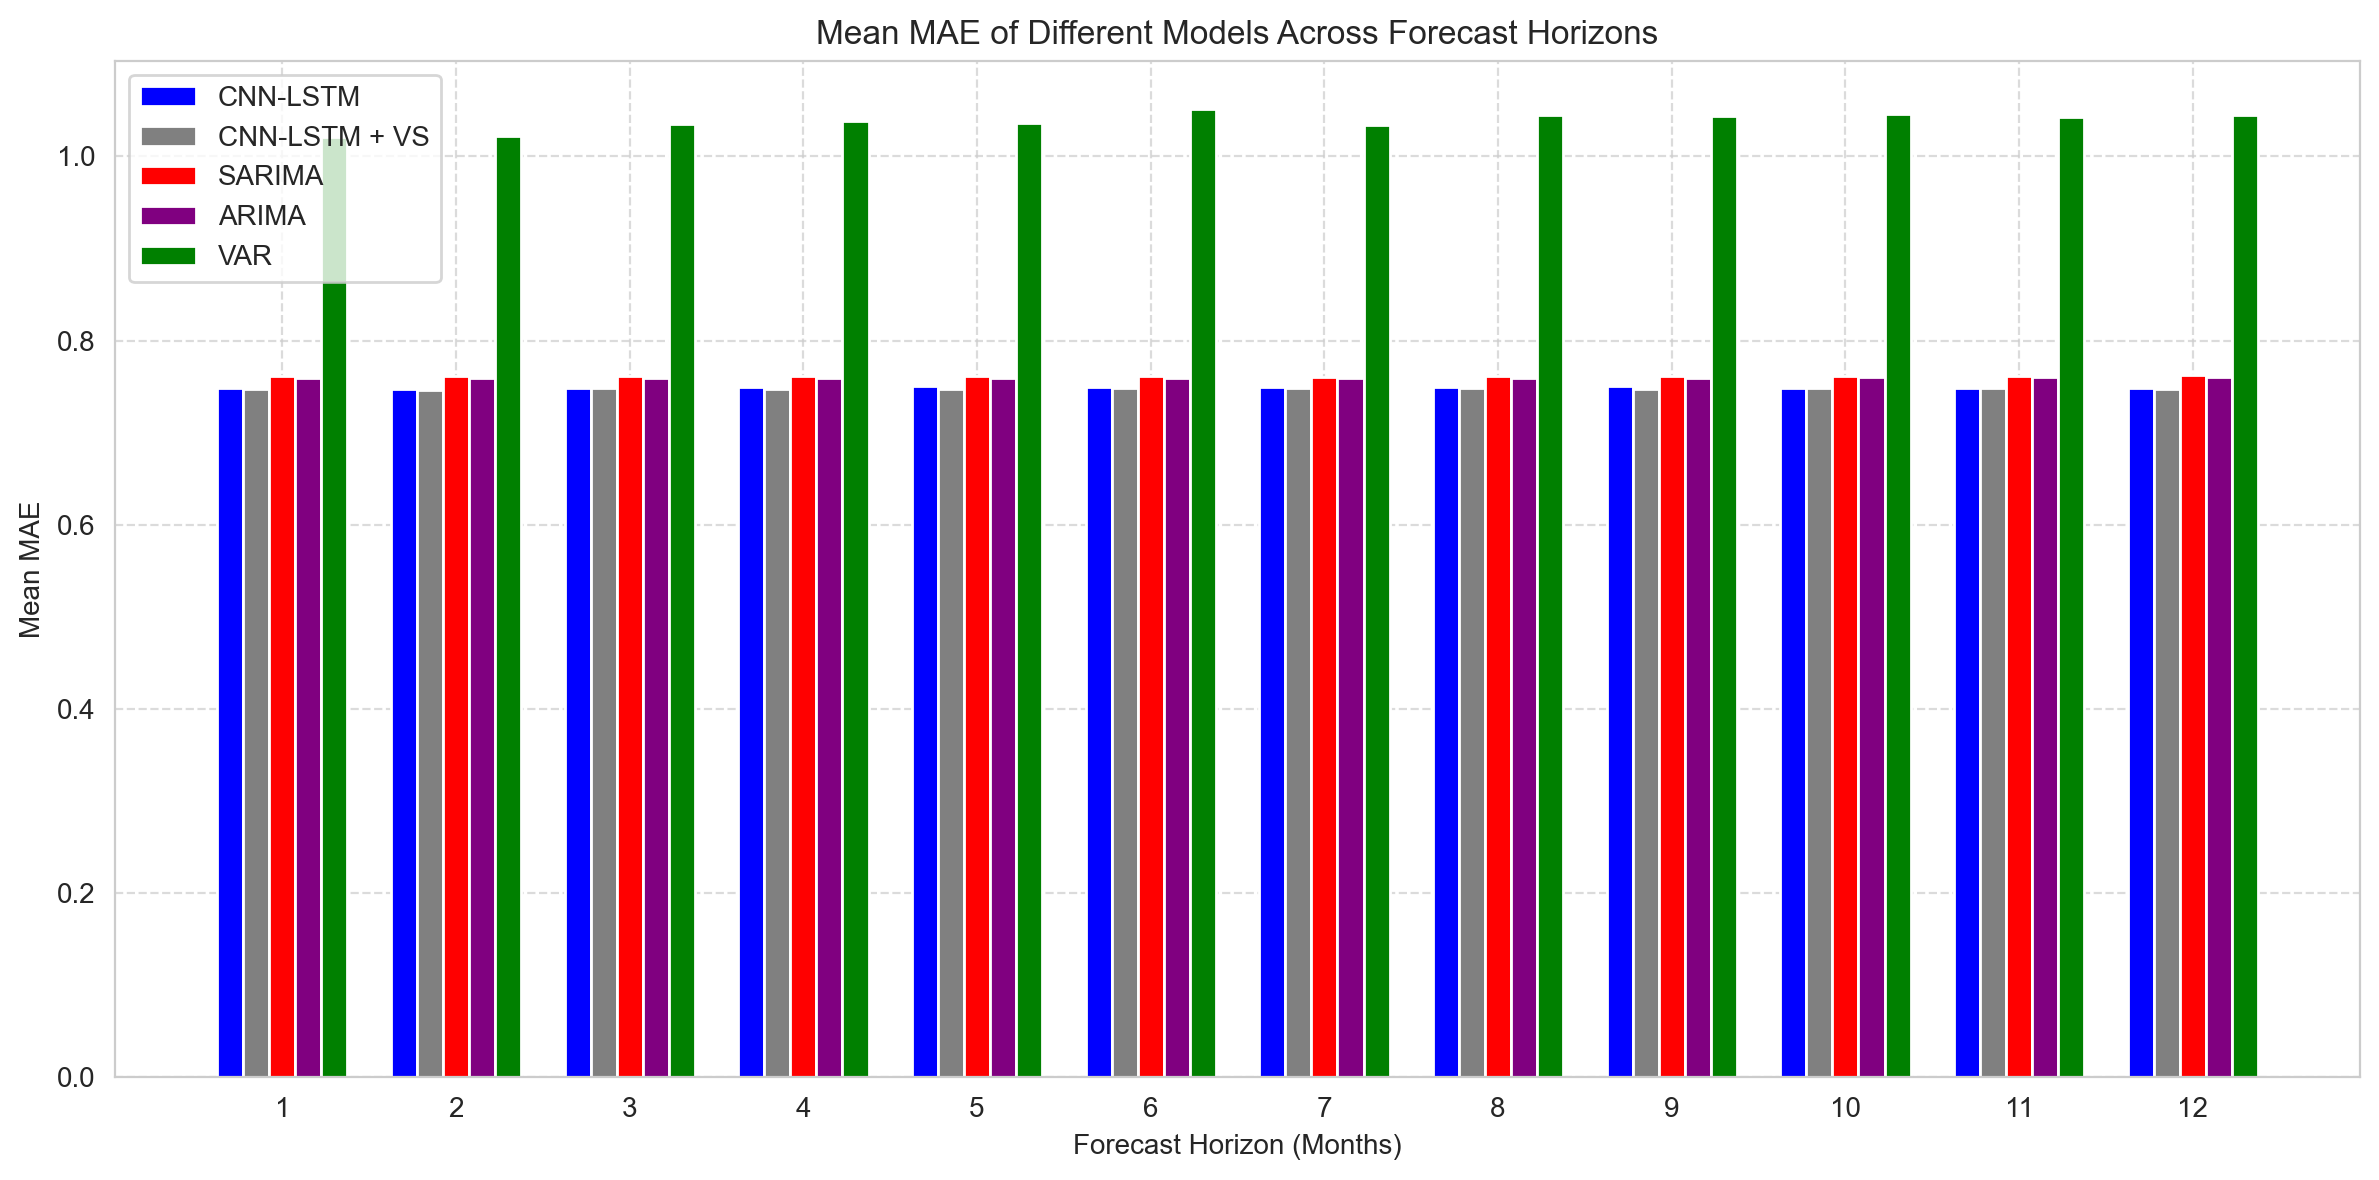

In [31]:

# Assuming mae_results dictionary is populated as in your previous code

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]
mae_results = {} # This should be populated from your file reading

for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))
        mean_maes = df_mae.mean()
        mae_results[steps] = mean_maes.to_dict()
    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")
        mae_results[steps] = {model: np.nan for model in models} # Use NaN if file not found

# Prepare data for plotting
num_horizons = len(forecast_horizons)
num_models = len(models)
bar_width = 0.15
index = np.arange(num_horizons)

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['blue', 'gray', 'red', 'purple', 'green'] # Define colors for each model
rects = []

for i, model in enumerate(models):
    mae_values = [mae_results[horizon].get(model, np.nan) for horizon in forecast_horizons]
    x_positions = index + (i * bar_width) - (num_models * bar_width / 2) + (bar_width / 2)
    rect = ax.bar(x_positions, mae_values, bar_width, label=model, color=colors[i])
    rects.append(rect)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Forecast Horizon (Months)')
ax.set_ylabel('Mean MAE')
ax.set_title('Mean MAE of Different Models Across Forecast Horizons')
ax.set_xticks(index)
ax.set_xticklabels(forecast_horizons)
ax.legend()

ax.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()

plt.show()

<function matplotlib.pyplot.xticks(ticks: 'ArrayLike | None' = None, labels: 'Sequence[str] | None' = None, *, minor: 'bool' = False, **kwargs) -> 'tuple[list[Tick] | np.ndarray, list[Text]]'>

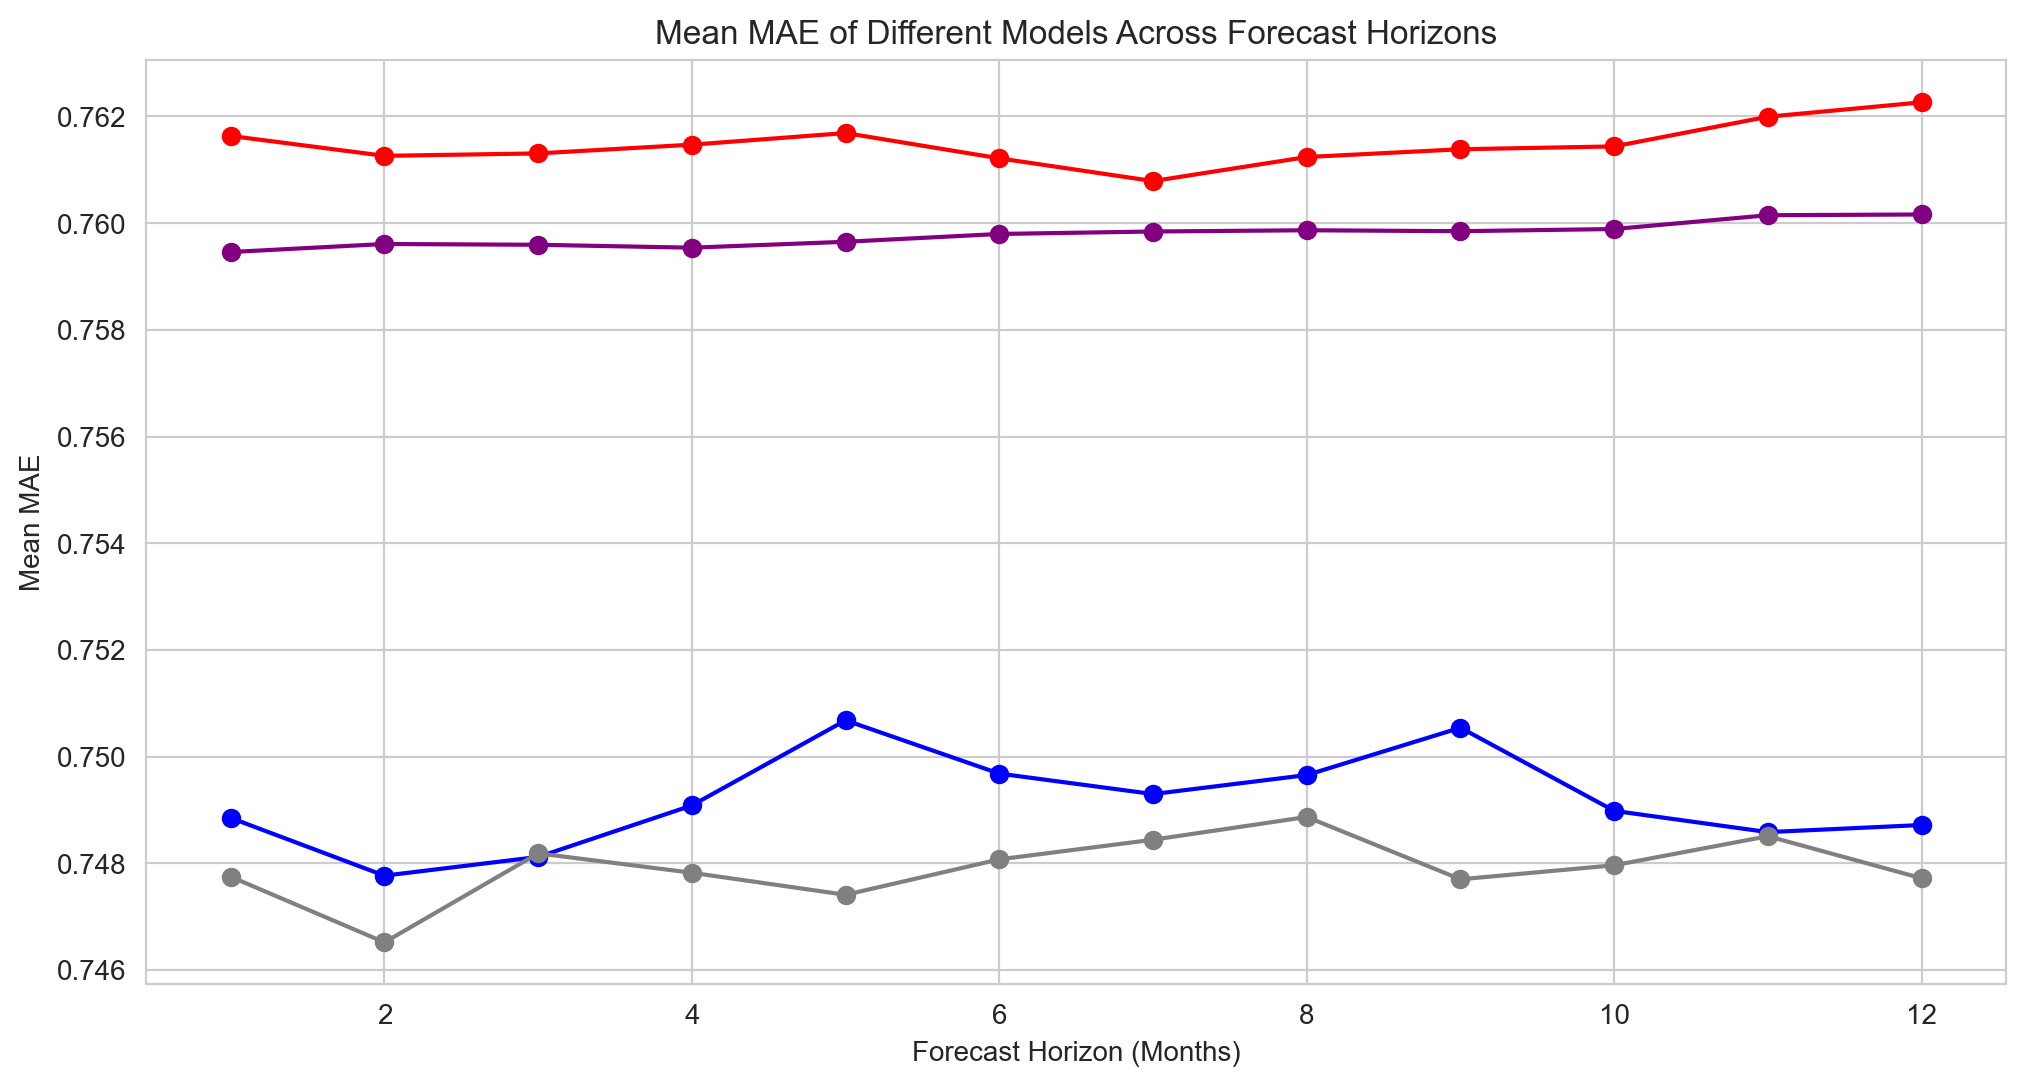

In [36]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA"]
mae_results = {}

# Populate mae_results from CSV files
for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))
        mean_maes = df_mae.mean()
        mae_results[steps] = mean_maes.to_dict()
    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")
        mae_results[steps] = {model: np.nan for model in models}

# Create the line plot
plt.figure(figsize=(12, 6))
colors = ['blue', 'gray', 'red', 'purple', 'green']  # Define colors for each model

for i, model in enumerate(models):
    mae_values = [mae_results[horizon].get(model, np.nan) for horizon in forecast_horizons]
    plt.plot(forecast_horizons, mae_values, marker='o', linestyle='-', color=colors[i], label=model)

# Customize the plot
plt.xlabel('Forecast Horizon (Months)')
plt.ylabel('Mean MAE')
plt.title('Mean MAE of Different Models Across Forecast Horizons')
plt.xticks

<function matplotlib.pyplot.xticks(ticks: 'ArrayLike | None' = None, labels: 'Sequence[str] | None' = None, *, minor: 'bool' = False, **kwargs) -> 'tuple[list[Tick] | np.ndarray, list[Text]]'>

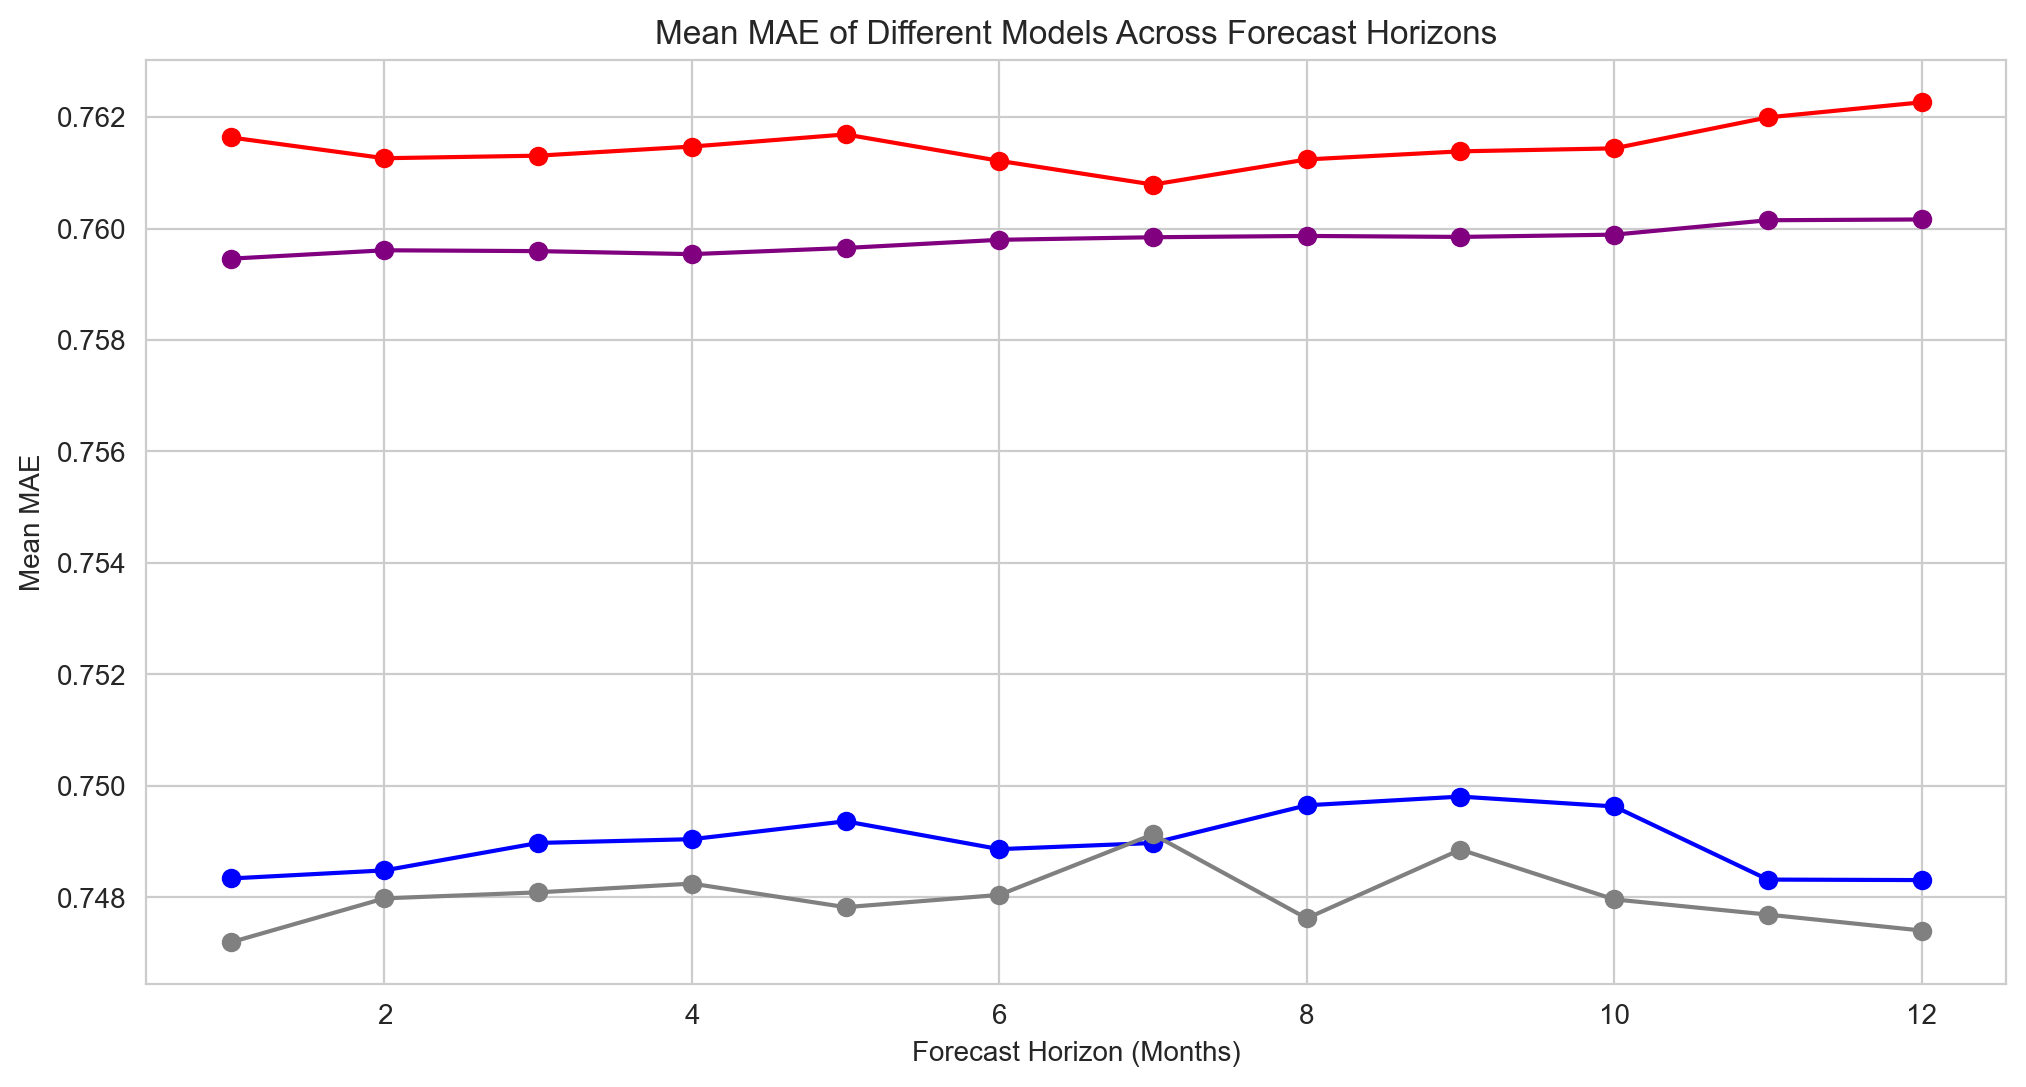

In [40]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA"]
mae_results = {}

# Populate mae_results from CSV files
for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))
        mean_maes = df_mae.mean()
        mae_results[steps] = mean_maes.to_dict()
    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")
        mae_results[steps] = {model: np.nan for model in models}

# Create the line plot
plt.figure(figsize=(12, 6))
colors = ['blue', 'gray', 'red', 'purple', 'green']  # Define colors for each model

for i, model in enumerate(models):
    mae_values = [mae_results[horizon].get(model, np.nan) for horizon in forecast_horizons]
    plt.plot(forecast_horizons, mae_values, marker='o', linestyle='-', color=colors[i], label=model)

# Customize the plot
plt.xlabel('Forecast Horizon (Months)')
plt.ylabel('Mean MAE')
plt.title('Mean MAE of Different Models Across Forecast Horizons')
plt.xticks

In [53]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]

# Plot the distribution of MAEs for each forecast horizon
for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_maes = pd.read_csv(os.path.join(m_result_Dir, filename_mae))

        plt.figure(figsize=(10, 6))
        sns.histplot(df_maes["CNN-LSTM"], kde=True, bins=20, label="CNN-LSTM", color="blue", alpha=0.6)
        sns.histplot(df_maes["CNN-LSTM + VS"], kde=True, bins=20, label="CNN-LSTM + VS", color="cyan", alpha=0.6)
        sns.histplot(df_maes["VAR"], kde=True, bins=20, label="VAR", color="green", alpha=0.6)
        sns.histplot(df_maes["SARIMA"], kde=True, bins=20, label="SARIMA", color="red", alpha=0.6)
        sns.histplot(df_maes["ARIMA"], kde=True, bins=20, label="ARIMA", color="purple", alpha=0.6)

        plt.legend()
        plt.title(f"Distribution of MAE values for {steps}-Month Ahead Forecast")
        plt.xlabel("MAE")
        plt.ylabel("Frequency")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")

In [52]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]

for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))

        print(f"\n--- Forecast Horizon: {steps}-Month Ahead ---")
        summary_data = {}
        for model in models:
            if model in df_mae.columns:
                summary_data[model] = {
                    "Average": df_mae[model].mean(),
                    "SD": df_mae[model].std(),
                    "Max": df_mae[model].max(),
                    "Min": df_mae[model].min(),
                }
            else:
                summary_data[model] = {
                    "Average": float('nan'),
                    "SD": float('nan'),
                    "Max": float('nan'),
                    "Min": float('nan'),
                }

        summary_df = pd.DataFrame.from_dict(summary_data, orient='index')
        # Sort the DataFrame by the 'Average' MAE column in ascending order
        summary_df_ordered = summary_df.sort_values(by="Average")
        print(summary_df_ordered)

    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")


--- Forecast Horizon: 1-Month Ahead ---
                Average        SD       Max       Min
CNN-LSTM + VS  0.747191  0.076577  1.018302  0.594343
CNN-LSTM       0.748337  0.076704  1.025911  0.582631
ARIMA          0.759459  0.077824  1.016969  0.593711
SARIMA         0.761635  0.079499  1.027726  0.592276
VAR            1.021285  0.119745  1.271465  0.730224

--- Forecast Horizon: 2-Month Ahead ---
                Average        SD       Max       Min
CNN-LSTM + VS  0.747980  0.076896  1.021961  0.582286
CNN-LSTM       0.748481  0.076192  1.009561  0.583097
ARIMA          0.759610  0.077793  1.017386  0.593742
SARIMA         0.761262  0.079569  1.028440  0.592990
VAR            1.022295  0.099146  1.252034  0.807682

--- Forecast Horizon: 3-Month Ahead ---
                Average        SD       Max       Min
CNN-LSTM + VS  0.748087  0.076690  1.026867  0.583413
CNN-LSTM       0.748974  0.075487  1.025642  0.603447
ARIMA          0.759595  0.077748  1.017520  0.593065
SARIMA       

In [51]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]

aggregated_stats = {model: {"Average": [], "SD": [], "Max": [], "Min": []} for model in models}

for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))

        for model in models:
            if model in df_mae.columns:
                aggregated_stats[model]["Average"].append(df_mae[model].mean())
                aggregated_stats[model]["SD"].append(df_mae[model].std())
                aggregated_stats[model]["Max"].append(df_mae[model].max())
                aggregated_stats[model]["Min"].append(df_mae[model].min())
            else:
                aggregated_stats[model]["Average"].append(float('nan'))
                aggregated_stats[model]["SD"].append(float('nan'))
                aggregated_stats[model]["Max"].append(float('nan'))
                aggregated_stats[model]["Min"].append(float('nan'))

    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")
        for model in models:
            aggregated_stats[model]["Average"].append(float('nan'))
            aggregated_stats[model]["SD"].append(float('nan'))
            aggregated_stats[model]["Max"].append(float('nan'))
            aggregated_stats[model]["Min"].append(float('nan'))

# Calculate the mean of each statistic across all horizons
final_summary_data = {}
for model, stats in aggregated_stats.items():
    final_summary_data[model] = {
        "Mean Average MAE": pd.Series(stats["Average"]).mean(),
        "Mean SD MAE": pd.Series(stats["SD"]).mean(),
        "Mean Max MAE": pd.Series(stats["Max"]).mean(),
        "Mean Min MAE": pd.Series(stats["Min"]).mean(),
    }

# Create a Pandas DataFrame from the final summary data
final_summary_df = pd.DataFrame.from_dict(final_summary_data, orient='index')

# Order the DataFrame by Mean Average MAE in ascending order
final_summary_df_ordered = final_summary_df.sort_values(by="Mean Average MAE")

print("\n--- Mean of Average, SD, Max, Min MAE Across All Horizons ---")
print(final_summary_df_ordered)


--- Mean of Average, SD, Max, Min MAE Across All Horizons ---
               Mean Average MAE  Mean SD MAE  Mean Max MAE  Mean Min MAE
CNN-LSTM + VS          0.748002     0.076910      1.021912      0.589240
CNN-LSTM               0.748978     0.076861      1.025772      0.588337
ARIMA                  0.759784     0.077805      1.017528      0.593698
SARIMA                 0.761474     0.079088      1.022552      0.595958
VAR                    1.038303     0.108480      1.338657      0.803477


In [69]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]
alpha = 0.05  # Significance level
normality_results_all_horizons = {}

print("Normality Tests (Shapiro-Wilk) for Model Performance (MAE):\n")

# --- First Pass: Test for Normality ---
for steps in forecast_horizons:
    filename = f"maess_{steps}_month_ahead.csv"
    normality_results_for_horizon = {}
    try:
        df_maes = pd.read_csv(os.path.join(m_result_Dir, filename))
        print(f"--- Forecast Horizon: {steps}_month_ahead ---")
        for model in models:
            try:
                statistic, p_value = stats.shapiro(df_maes[model])
                is_normal = p_value > alpha
                normality_results_for_horizon[model] = is_normal
                print(f"  Model: {model}, Shapiro-Wilk Statistic: {statistic:.4f}, P-value: {p_value:.4f}, Likely Normal: {is_normal}")
            except Exception as e:
                print(f"  Error during normality test for {model}: {e}")
                normality_results_for_horizon[model] = False # Assume not normal if error
        normality_results_all_horizons[f"{steps}_month_ahead"] = normality_results_for_horizon
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found for {steps}-month ahead.\n")
        normality_results_all_horizons[f"{steps}_month_ahead"] = {model: False for model in models}

print("\nPairwise Significance Tests based on Normality (alpha=0.05):\n")


Normality Tests (Shapiro-Wilk) for Model Performance (MAE):

--- Forecast Horizon: 1_month_ahead ---
  Model: CNN-LSTM, Shapiro-Wilk Statistic: 0.9684, P-value: 0.0167, Likely Normal: False
  Model: CNN-LSTM + VS, Shapiro-Wilk Statistic: 0.9666, P-value: 0.0122, Likely Normal: False
  Model: SARIMA, Shapiro-Wilk Statistic: 0.9768, P-value: 0.0752, Likely Normal: True
  Model: ARIMA, Shapiro-Wilk Statistic: 0.9763, P-value: 0.0687, Likely Normal: True
  Model: VAR, Shapiro-Wilk Statistic: 0.9805, P-value: 0.1455, Likely Normal: True
--- Forecast Horizon: 2_month_ahead ---
  Model: CNN-LSTM, Shapiro-Wilk Statistic: 0.9743, P-value: 0.0477, Likely Normal: False
  Model: CNN-LSTM + VS, Shapiro-Wilk Statistic: 0.9695, P-value: 0.0204, Likely Normal: False
  Model: SARIMA, Shapiro-Wilk Statistic: 0.9753, P-value: 0.0564, Likely Normal: True
  Model: ARIMA, Shapiro-Wilk Statistic: 0.9762, P-value: 0.0673, Likely Normal: True
  Model: VAR, Shapiro-Wilk Statistic: 0.9872, P-value: 0.4502, Likel

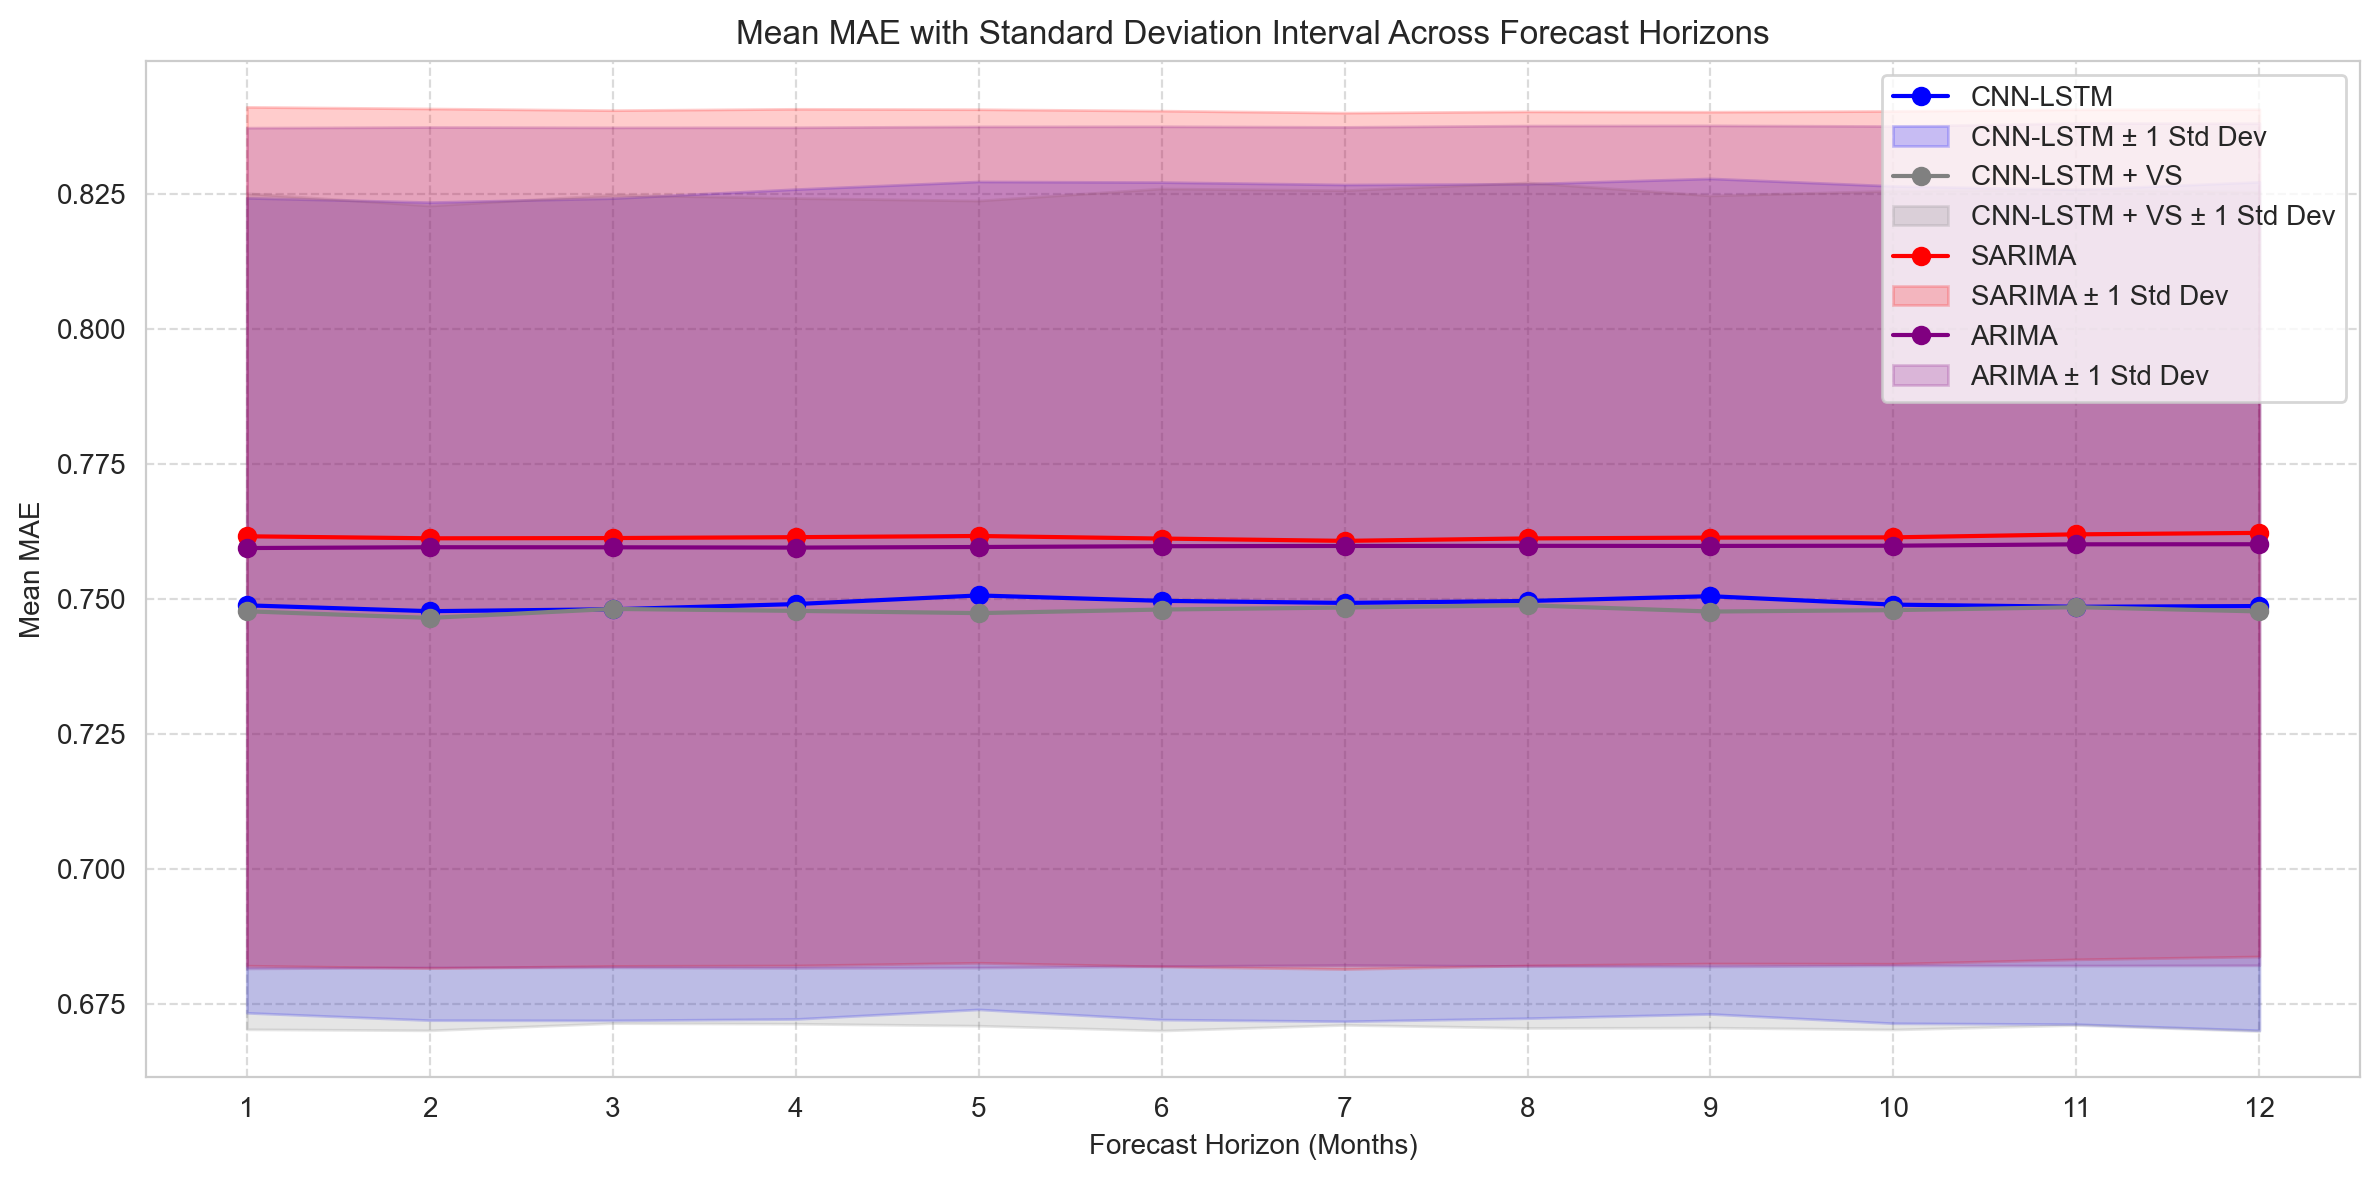

In [39]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA"]
mean_mae_results = {}
std_mae_results = {}

# Populate mean_mae_results and std_mae_results from CSV files
for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))
        mean_mae_results[steps] = df_mae.mean().to_dict()
        std_mae_results[steps] = df_mae.std().to_dict()
    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")
        mean_mae_results[steps] = {model: np.nan for model in models}
        std_mae_results[steps] = {model: np.nan for model in models}

# Create the line plot with confidence intervals
plt.figure(figsize=(12, 6))
colors = ['blue', 'gray', 'red', 'purple', 'green']  # Define colors for each model

for i, model in enumerate(models):
    mean_mae_values = [mean_mae_results[horizon].get(model, np.nan) for horizon in forecast_horizons]
    std_mae_values = [std_mae_results[horizon].get(model, np.nan) for horizon in forecast_horizons]

    # Plot mean MAE
    plt.plot(forecast_horizons, mean_mae_values, marker='o', linestyle='-', color=colors[i], label=model)

    # Plot confidence interval (using one standard deviation)
    lower_bound = np.array(mean_mae_values) - np.array(std_mae_values)
    upper_bound = np.array(mean_mae_values) + np.array(std_mae_values)
    plt.fill_between(forecast_horizons, lower_bound, upper_bound, color=colors[i], alpha=0.2, label=f'{model} ± 1 Std Dev')

# Customize the plot
plt.xlabel('Forecast Horizon (Months)')
plt.ylabel('Mean MAE')
plt.title('Mean MAE with Standard Deviation Interval Across Forecast Horizons')
plt.xticks(forecast_horizons)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:

# # --- Second Pass: Perform Significance Tests ---
# for steps in forecast_horizons:
#     filename = f"maess_{steps}_month_ahead.csv"
#     horizon_str = f"{steps}_month_ahead"
#     normality_results = normality_results_all_horizons.get(horizon_str, {})
#     try:
#         df_maes = pd.read_csv(os.path.join(m_result_Dir, filename))
#         print(f"--- Forecast Horizon: {horizon_str} ---")
#         for i in range(len(models)):
#             for j in range(i + 1, len(models)):
#                 model1 = models[i]
#                 model2 = models[j]
# 
#                 print(f"\nComparison: {model1} vs {model2}")
# 
#                 normal_model1 = normality_results.get(model1, False)
#                 normal_model2 = normality_results.get(model2, False)
# 
#                 try:
#                     if normal_model1 and normal_model2:
#                         # Perform Paired t-test if both are likely normal
#                         result = stats.ttest_rel(df_maes[model1], df_maes[model2])
#                         p_value = result.pvalue
#                         statistic = result.statistic
#                         test_type = "Paired t-test"
#                     else:
#                         # Perform Wilcoxon signed-rank test if at least one is not normal
#                         result = stats.wilcoxon(df_maes[model1], df_maes[model2])
#                         p_value = result.pvalue
#                         statistic = result.statistic
#                         test_type = "Wilcoxon Signed-Rank Test"
# 
#                     if p_value < alpha:
#                         significance = "Significant"
#                     else:
#                         significance = "Not Significant"
# 
#                     print(f"  Test Used: {test_type}")
#                     print(f"  Statistic: {statistic:.4f}")
#                     print(f"  P-value: {p_value:.4f}")
#                     print(f"  Difference is {significance} (alpha={alpha})\n")
# 
#                 except ValueError as e:
#                     print(f"  Error comparing {model1} and {model2}: {e}. Likely due to identical values.")
#                     print("  Consider inspecting the data.\n")
# 
#     except FileNotFoundError:
#         print(f"Error: File '{filename}' not found for {horizon_str}.\n")
# 
# print("\nNote: Shapiro-Wilk test checks if the data is likely drawn from a normal distribution (alpha=0.05).")
# print("Pairwise significance tests are chosen based on these normality test results.")

--- Forecast Horizon: 1_month_ahead ---

Comparison: CNN-LSTM vs CNN-LSTM + VS
  Test Used: Paired t-test
  Statistic: 2.6121
  P-value: 0.0104
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM vs SARIMA
  Test Used: Paired t-test
  Statistic: -3.6728
  P-value: 0.0004
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM vs ARIMA
  Test Used: Paired t-test
  Statistic: -4.0456
  P-value: 0.0001
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM vs VAR
  Test Used: Paired t-test
  Statistic: -16.4166
  P-value: 0.0000
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM + VS vs SARIMA
  Test Used: Paired t-test
  Statistic: -4.5081
  P-value: 0.0000
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM + VS vs ARIMA
  Test Used: Paired t-test
  Statistic: -5.0790
  P-value: 0.0000
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM + VS vs VAR
  Test Used: Paired t-test
  Statistic: -16.8007
  P-value: 0.0000
  Diffe